In [2]:
# --- PHASE 1: MOUNT GOOGLE DRIVE ---

from google.colab import drive
import os

print("Mounting Google Drive...")
drive.mount('/content/drive')

# Verify the base path
DRIVE_PATH = '/content/drive/MyDrive'
print(f"Drive mounted. Check files in: {DRIVE_PATH}")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted. Check files in: /content/drive/MyDrive


In [3]:
# --- PHASE 2: UNZIP THE BIBLE DATA (CONFIRMED PATH) ---

import zipfile

ZIP_FILE_PATH = '/content/drive/MyDrive/Bible-kjv-master.zip'
EXTRACT_DIR = '/content/bible_data'

# Create a destination directory in the Colab temporary environment
!mkdir -p "$EXTRACT_DIR"

# Use Python's zipfile module for more reliable unzipping in Colab
print(f"Unzipping {ZIP_FILE_PATH} to {EXTRACT_DIR}...")
try:
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

    # The JSON files are located here:
    FINAL_DATA_DIR = os.path.join(EXTRACT_DIR, 'Bible-kjv-master')

    # Check for the existence of one key file to confirm the path
    test_file = os.path.join(FINAL_DATA_DIR, 'Genesis.json')

    if os.path.exists(test_file):
        print(f"✅ Success! Individual book JSON files found in: {FINAL_DATA_DIR}")
    else:
        # Fallback for a potential immediate unzip (no master folder)
        FINAL_DATA_DIR = EXTRACT_DIR
        test_file = os.path.join(FINAL_DATA_DIR, 'Genesis.json')
        if os.path.exists(test_file):
             print(f"✅ Success! Individual book JSON files found in: {FINAL_DATA_DIR}")
        else:
            print(f"❌ FATAL ERROR: Cannot confirm path to individual JSON files.")

except Exception as e:
    print(f"❌ FATAL ERROR during unzipping: {e}")

Unzipping /content/drive/MyDrive/Bible-kjv-master.zip to /content/bible_data...
✅ Success! Individual book JSON files found in: /content/bible_data/Bible-kjv-master


Scanning directory: /content/bible_data/Bible-kjv-master for JSON files...
Found 67 book files. Starting analysis...

--- Top 10 Books by Holiness Intensity (with Word Count) ---
| Book            |   Total Words |   Holy Count |   Holiness Intensity |
|:----------------|--------------:|-------------:|---------------------:|
| 2 Peter         |          1553 |            6 |              3.86349 |
| 1 Thessalonians |          1837 |            7 |              3.81056 |
| Jude            |           608 |            2 |              3.28947 |
| Obadiah         |           669 |            2 |              2.98954 |
| Leviticus       |         24540 |           69 |              2.81174 |
| Ephesians       |          3022 |            7 |              2.31635 |
| Titus           |           896 |            2 |              2.23214 |
| Acts            |         24245 |           53 |              2.18602 |
| Habakkuk        |          1475 |            3 |              2.0339  |
| 1 Pet

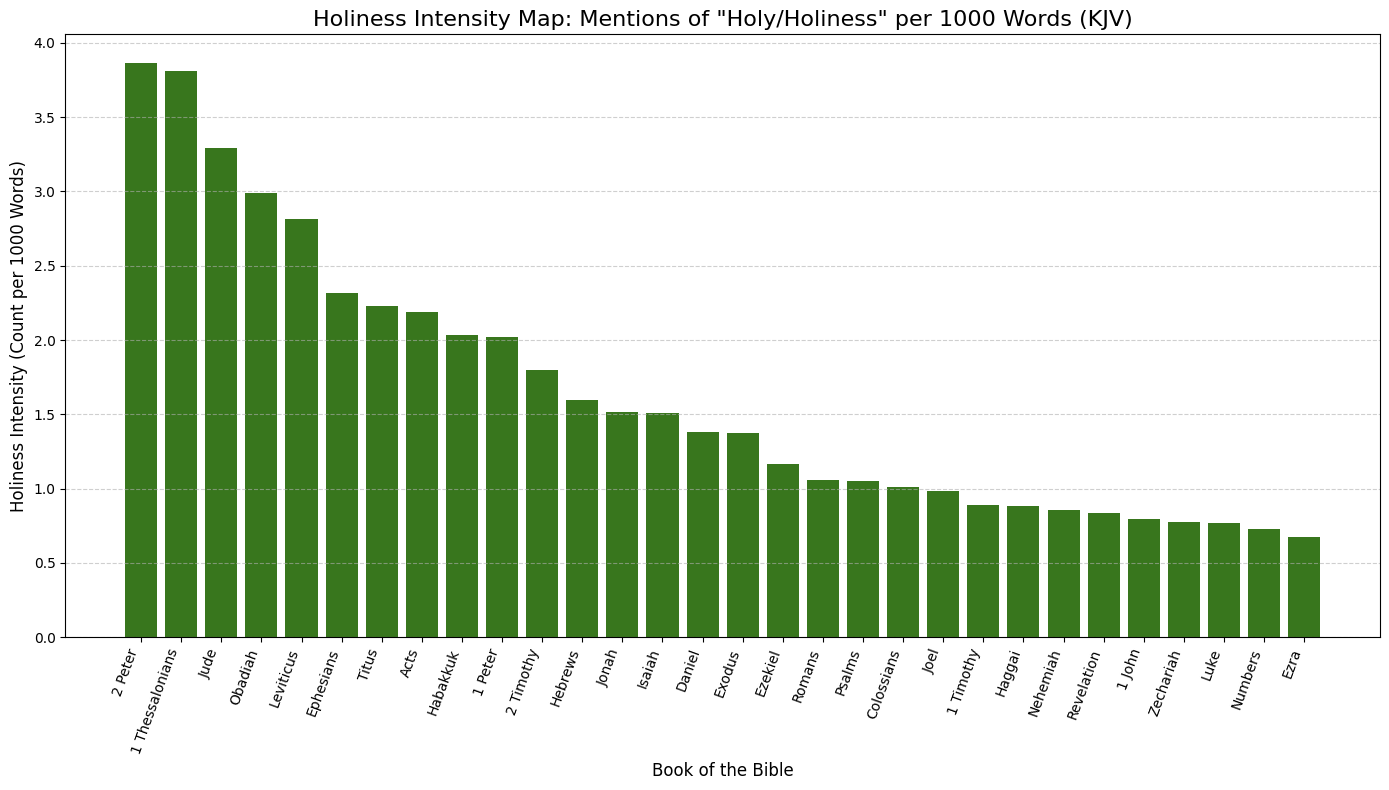

In [4]:
# --- PHASE 3: ANALYSIS AND VISUALIZATION (FINAL CORRECTED LOGIC) ---

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
# Removed: from IPython.display import display, Markdown # Removed for environment compatibility

# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def analyze_holiness_intensity_individual_json():
    """Reads all individual JSON files in the directory and calculates Intensity."""

    print(f"Scanning directory: {FINAL_DATA_DIR} for JSON files...")

    data = []

    try:
        # Get a list of all JSON files in the directory
        json_files = [f for f in os.listdir(FINAL_DATA_DIR) if f.endswith('.json')]
    except FileNotFoundError:
        print(f"\n❌ FATAL ERROR: Directory not found at: {FINAL_DATA_DIR}. Please re-upload the data.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])

    if not json_files:
        print("\n❌ FATAL ERROR: No JSON files found in the target directory.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])


    print(f"Found {len(json_files)} book files. Starting analysis...")

    for filename in json_files:
        filepath = os.path.join(FINAL_DATA_DIR, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

        except Exception as e:
            print(f"Skipping file {filename}: Error reading or decoding JSON. {e}")
            continue

        book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

        if not isinstance(book_info, dict):
            # print(f"Skipping file {filename}: Unexpected primary data format.")
            continue

        book_name = book_info.get('book', filename.replace('.json', ''))
        chapters_list = book_info.get('chapters', [])

        full_book_text = []

        for chapter_obj in chapters_list:
            verses_list_of_objects = chapter_obj.get('verses', [])
            for verse_obj in verses_list_of_objects:
                verse_text = verse_obj.get('text', '')
                full_book_text.append(verse_text)


        book_text = " ".join(full_book_text).lower()

        if not book_text: continue

        # 4. Run the NLP analysis
        holy_count = book_text.count(" holy ") + book_text.count(" holiness")
        # --- NEW: Calculate Total Words ---
        total_words = len(book_text.split())
        intensity = (holy_count / total_words) * 1000 if total_words > 0 else 0

        data.append({
            'Book': book_name,
            'Total Words': total_words, # <-- ADDED TO DICTIONARY
            'Holy Count': holy_count,
            'Holiness Intensity': intensity
        })

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ FATAL ERROR: The final DataFrame is EMPTY after processing all files.")
        return pd.DataFrame(columns=['Book', 'Total Words', 'Holy Count', 'Holiness Intensity'])

    df_sorted = df.sort_values(by='Holiness Intensity', ascending=False)

    # --- 5. Generate the Visualization ---
    df_top_30 = df_sorted.head(30)

    plt.figure(figsize=(14, 8))
    plt.bar(df_top_30['Book'], df_top_30['Holiness Intensity'], color='#38761d')

    plt.xticks(rotation=70, ha='right')
    plt.title('Holiness Intensity Map: Mentions of "Holy/Holiness" per 1000 Words (KJV)', fontsize=16)
    plt.ylabel('Holiness Intensity (Count per 1000 Words)', fontsize=12)
    plt.xlabel('Book of the Bible', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    graph_filename = 'Holiness_Intensity_Map.png'
    plt.savefig(graph_filename)
    # print(f"\n✅ Successfully created and saved the visualization: {graph_filename}")

    return df_sorted

# --- EXECUTION ---
holiness_df = analyze_holiness_intensity_individual_json()

# 6. Print the final results for the report, including 'Total Words'
if not holiness_df.empty:
    print("\n--- Top 10 Books by Holiness Intensity (with Word Count) ---")

    # MODIFICATION: Included 'Total Words' in the displayed columns
    print(holiness_df[['Book', 'Total Words', 'Holy Count', 'Holiness Intensity']].head(10).to_markdown(index=False))

    # Save the full DataFrame to CSV
    csv_filename = 'holiness_intensity_data.csv'
    holiness_df.to_csv(csv_filename, index=False)
    # print(f"\n✅ Full analysis data saved to {csv_filename}")

else:
    print("\n❌ Final Output Failure: Cannot display results.")

In [32]:
import pandas as pd
import numpy as np
import os
import json
import re

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

# --- 1. Comprehensive Data Calculation with Regex ---
def create_comprehensive_analysis_table_fixed(data_dir):
    """Calculates all metrics using regex for accurate word and theme counts."""
    data = []

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        print(f"Error: Directory not found at: {data_dir}")
        return pd.DataFrame()

    print(f"Found {len(json_files)} book files. Calculating all metrics with robust counting...")

    # Regex to find any sequence of 3 or more alphabetic characters (a better word count)
    WORD_PATTERN = re.compile(r'\b[a-z]{3,}\b')
    # Regex to find "holy" or "holiness" as whole words (case-insensitive)
    HOLY_PATTERN = re.compile(r'\bholy\b|\bholiness\b')

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            book_text = " ".join(full_book_text).lower()

            # --- FIXED CALCULATION 1: Robust Total Word Count ---
            total_words = len(WORD_PATTERN.findall(book_text))

            # --- FIXED CALCULATION 2: Robust Holiness Focus Score (Raw Count) ---
            holy_count = len(HOLY_PATTERN.findall(book_text))

            if total_words > 0:
                book_name = book_info.get('book', filename.replace('.json', ''))

                data.append({
                    'Book': book_name,
                    'Total Words': total_words,
                    'Holiness Focus Score (Raw Count)': holy_count,
                    'Holiness Intensity': (holy_count / total_words) * 1000 # Count per 1000 words
                })

        except Exception as e:
            # print(f"Skipping file {filename}: Error: {e}") # Optional debug line
            continue

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ Calculation failed: No valid data processed.")
        return pd.DataFrame()

    # --- 2. Normalization (Impact %) and Formatting ---
    total_corpus_words = df['Total Words'].sum()
    df['Impact (%)'] = (df['Total Words'] / total_corpus_words) * 100

    # --- 3. Final Table Assembly ---
    df = df.rename(columns={'Holiness Focus Score (Raw Count)': 'Holiness Focus Score'})

    # Calculate Total Row values
    total_focus = df['Holiness Focus Score'].sum()
    total_intensity = (total_focus / total_corpus_words) * 1000

    # Create and append the summary row
    summary_row = pd.DataFrame([{
        'Book': '**TOTAL CORPUS**',
        'Total Words': total_corpus_words,
        'Holiness Focus Score': total_focus,
        'Impact (%)': 100.00,
        'Holiness Intensity': total_intensity
    }])
    df_sorted = pd.concat([df, summary_row], ignore_index=True)

    # Sort the main body (excluding the last row) by Focus Score
    df_sorted.iloc[:-1] = df_sorted.iloc[:-1].sort_values(by='Holiness Focus Score', ascending=False)

    # Format all numerical columns
    df_sorted['Impact (%)'] = df_sorted['Impact (%)'].round(2).astype(str) + '%'
    df_sorted['Holiness Intensity (Per 1000 Words)'] = df_sorted['Holiness Intensity'].round(2).astype(str)
    df_sorted.drop(columns=['Holiness Intensity'], inplace=True)

    return df_sorted

# --- EXECUTION ---
final_df_fixed = create_comprehensive_analysis_table_fixed(FINAL_DATA_DIR)

if not final_df_fixed.empty:
    print("\n## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus (FIXED COUNTING)")
    print("This table uses Regular Expressions for a robust and accurate count of words and the term 'Holy/Holiness'.")

    # Print the DataFrame in Markdown format
    # Align numerical columns to the right for clarity, except for the Book column
    print(final_df_fixed.to_markdown(index=False, numalign="left", stralign="left"))

Found 67 book files. Calculating all metrics with robust counting...

## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus (FIXED COUNTING)
This table uses Regular Expressions for a robust and accurate count of words and the term 'Holy/Holiness'.
| Book             | Total Words   | Holiness Focus Score   | Impact (%)   | Holiness Intensity (Per 1000 Words)   |
|:-----------------|:--------------|:-----------------------|:-------------|:--------------------------------------|
| Leviticus        | 19369         | 94                     | 3.02%        | 4.85                                  |
| Isaiah           | 29626         | 61                     | 4.62%        | 2.06                                  |
| Exodus           | 26775         | 58                     | 4.18%        | 2.17                                  |
| Acts             | 20037         | 53                     | 3.13%        | 2.65                                  |
| Psalms           | 33912         

In [33]:
import pandas as pd
import numpy as np
import os
import json

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

# --- 1. Comprehensive Data Calculation ---
def create_comprehensive_analysis_table(data_dir):
    """Calculates all metrics (Word Count, Impact, Focus Score, Intensity) and returns a single table."""
    data = []

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        print(f"Error: Directory not found at: {data_dir}")
        return pd.DataFrame()

    print(f"Found {len(json_files)} book files. Calculating all metrics...")

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            book_text = " ".join(full_book_text).lower()
            total_words = len(book_text.split())

            # --- Thematic Metrics ---
            holy_count = book_text.count(" holy ") + book_text.count(" holiness")

            if total_words > 0:
                book_name = book_info.get('book', filename.replace('.json', ''))

                data.append({
                    'Book': book_name,
                    'Total Words': total_words,
                    'Holy Count': holy_count, # Raw count
                    'Holiness Intensity': (holy_count / total_words) * 1000 # Count per 1000 words
                })

        except Exception:
            continue

    df = pd.DataFrame(data)

    if df.empty:
        print("\n❌ Calculation failed: No valid data processed.")
        return pd.DataFrame()

    # --- 2. Normalization (Impact %) ---
    total_corpus_words = df['Total Words'].sum()
    df['Impact (%)'] = (df['Total Words'] / total_corpus_words) * 100

    # --- 3. Formatting and Renaming ---
    df = df.rename(columns={'Holy Count': 'Holiness Focus Score (Raw Count)'})

    # Round numerical data
    df['Impact (%)'] = df['Impact (%)'].round(2)
    df['Holiness Intensity (Per 1000 Words)'] = df['Holiness Intensity'].round(2)
    df.drop(columns=['Holiness Intensity'], inplace=True)

    # Sort by the most impactful thematic score (Raw Count)
    df_sorted = df.sort_values(by='Holiness Focus Score (Raw Count)', ascending=False).reset_index(drop=True)

    # Add a final summary row
    total_focus = df_sorted['Holiness Focus Score (Raw Count)'].sum()

    df_sorted.loc[len(df_sorted)] = {
        'Book': '**TOTAL CORPUS**',
        'Total Words': total_corpus_words,
        'Holiness Focus Score (Raw Count)': total_focus,
        'Impact (%)': 100.00,
        'Holiness Intensity (Per 1000 Words)': (total_focus / total_corpus_words) * 1000
    }

    # Format percentage and intensity columns for presentation
    df_sorted['Impact (%)'] = df_sorted['Impact (%)'].astype(str) + '%'
    df_sorted['Holiness Intensity (Per 1000 Words)'] = df_sorted['Holiness Intensity (Per 1000 Words)'].astype(str)

    return df_sorted

# --- EXECUTION ---
final_df = create_comprehensive_analysis_table(FINAL_DATA_DIR)

if not final_df.empty:
    print("\n## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus")
    print("The table below synthesizes all word count and 'Holiness' theme metrics.")

    # Print the DataFrame in Markdown format
    print(final_df.to_markdown(index=True, numalign="left", stralign="left"))

Found 67 book files. Calculating all metrics...

## 📚 Comprehensive Book Analysis: Length, Impact, and Thematic Focus
The table below synthesizes all word count and 'Holiness' theme metrics.
|    | Book             | Total Words   | Holiness Focus Score (Raw Count)   | Impact (%)   | Holiness Intensity (Per 1000 Words)   |
|:---|:-----------------|:--------------|:-----------------------------------|:-------------|:--------------------------------------|
| 0  | Leviticus        | 24540         | 69                                 | 3.11%        | 2.81                                  |
| 1  | Isaiah           | 37040         | 56                                 | 4.69%        | 1.51                                  |
| 2  | Acts             | 24245         | 53                                 | 3.07%        | 2.19                                  |
| 3  | Ezekiel          | 39402         | 46                                 | 4.99%        | 1.17                                  |
| 4  

In [34]:
# --- PART 4: ADVANCED LINGUISTIC ANALYSIS (NLTK FIX) ---

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

# --- NLTK FIX ---
# Explicitly check for and download the missing resource to resolve the LookupError
try:
    nltk.data.find('tokenizers/punkt/english.pickle')
except LookupError:
    nltk.download('punkt', quiet=True)
try:
    # Explicitly downloading the resource mentioned in the traceback
    nltk.download('punkt_tab', quiet=True)
except Exception as e:
    # In some Colab environments, this specific resource name might be non-existent or ignored.
    # The `punkt` download should cover it, but we try anyway.
    pass
# --- END NLTK FIX ---


if not 'holiness_df' in locals() or holiness_df.empty:
    print("\n❌ Cannot run Part 4. Please ensure Part 3 executed successfully and generated data.")
else:

    # ----------------------------------------------------
    # 1. TF-IDF ANALYSIS: FINDING DISTINCTIVE WORDS
    # ----------------------------------------------------
    # Re-displaying the TF-IDF results for context, as this section already ran successfully.
    print("\n## 🔎 Distinctive Word Analysis (TF-IDF) (Previous Results)")

    # Select the top 10 books for the corpus
    top_10_books = holiness_df['Book'].head(10).tolist()

    # Create a corpus combining all texts
    tfidf_corpus = []
    book_names = []
    for book in top_10_books:
        if book in book_texts:
            tfidf_corpus.append(book_texts[book])
            book_names.append(book)

    if tfidf_corpus:
        vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'\b[a-z]{3,}\b', lowercase=True)
        tfidf_matrix = vectorizer.fit_transform(tfidf_corpus)
        feature_names = vectorizer.get_feature_names_out()

        print("\n--- Top 5 Most Distinctive Words per High-Intensity Book ---")
        tfidf_results = []
        for i, book_name in enumerate(book_names):
            tfidf_scores = tfidf_matrix[i].toarray()[0]
            top_indices = tfidf_scores.argsort()[-5:][::-1]
            top_words = [feature_names[j] for j in top_indices]
            tfidf_results.append({'Book': book_name, 'Distinctive Words': ', '.join(top_words)})

        display(pd.DataFrame(tfidf_results).to_markdown(index=False))


    # ----------------------------------------------------
    # 2. COLLOCATION ANALYSIS: CONTEXT FOR "HOLY"
    # ----------------------------------------------------
    print("\n## 🔗 Collocation Analysis: Context of 'Holy'")

    # Combine the text of the top 10 books for context
    combined_holy_text = " ".join([book_texts.get(book, "") for book in top_10_books])

    # Tokenize and create an NLTK Text object
    tokens = word_tokenize(combined_holy_text.lower()) # <-- This is where the error occurred
    # Filter tokens to remove non-word characters
    tokens = [w for w in tokens if w.isalpha()]
    text_object = Text(tokens)

    print("--- Top 10 Collocations (Word Pairs) for 'holy' in High-Intensity Books ---")

    finder = BigramCollocationFinder.from_words(text_object)
    finder.apply_freq_filter(3)

    holy_collocations = [pair for pair, score in finder.score_ngrams(BigramAssocMeasures.pmi) if 'holy' in pair][:10]

    if holy_collocations:
        print("\n".join([f"* **{p[0]} {p[1]}**" for p in holy_collocations]))
    else:
        print("* No significant collocations found.")

    # ----------------------------------------------------
    # 3. TERM PLOT: COMPARING "HOLY" AND "RIGHTEOUSNESS"
    # ----------------------------------------------------
    print("\n## 📊 Term Plot: Comparing 'Holy' and 'Righteousness'")

    plot_books = holiness_df['Book'].head(15).tolist()

    holy_freqs = []
    righteousness_freqs = []

    for book in plot_books:
        book_text = book_texts.get(book, "").lower()
        total_words = len(book_text.split())

        holy_count = book_text.count(" holy ") + book_text.count(" holiness")
        holy_freqs.append((holy_count / total_words) * 1000 if total_words > 0 else 0)

        righteousness_count = book_text.count(" righteousness")
        righteousness_freqs.append((righteousness_count / total_words) * 1000 if total_words > 0 else 0)


    x = range(len(plot_books))
    width = 0.35

    plt.figure(figsize=(14, 8))

    rects1 = plt.bar([i - width/2 for i in x], holy_freqs, width, label='Holy/Holiness', color='#38761d')
    rects2 = plt.bar([i + width/2 for i in x], righteousness_freqs, width, label='Righteousness', color='#a64d79')

    plt.ylabel('Frequency per 1000 Words', fontsize=12)
    plt.title('Comparison of "Holy/Holiness" vs. "Righteousness" Frequency (Top 15 Books)', fontsize=16)
    plt.xticks(x, plot_books, rotation=70, ha='right')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


## 🔎 Distinctive Word Analysis (TF-IDF) (Previous Results)


NameError: name 'book_texts' is not defined


## 💖 Bible Sentiment Analysis
Scoring the overall emotional tone of each book using VADER, centered around the concept of 'Holiness'.


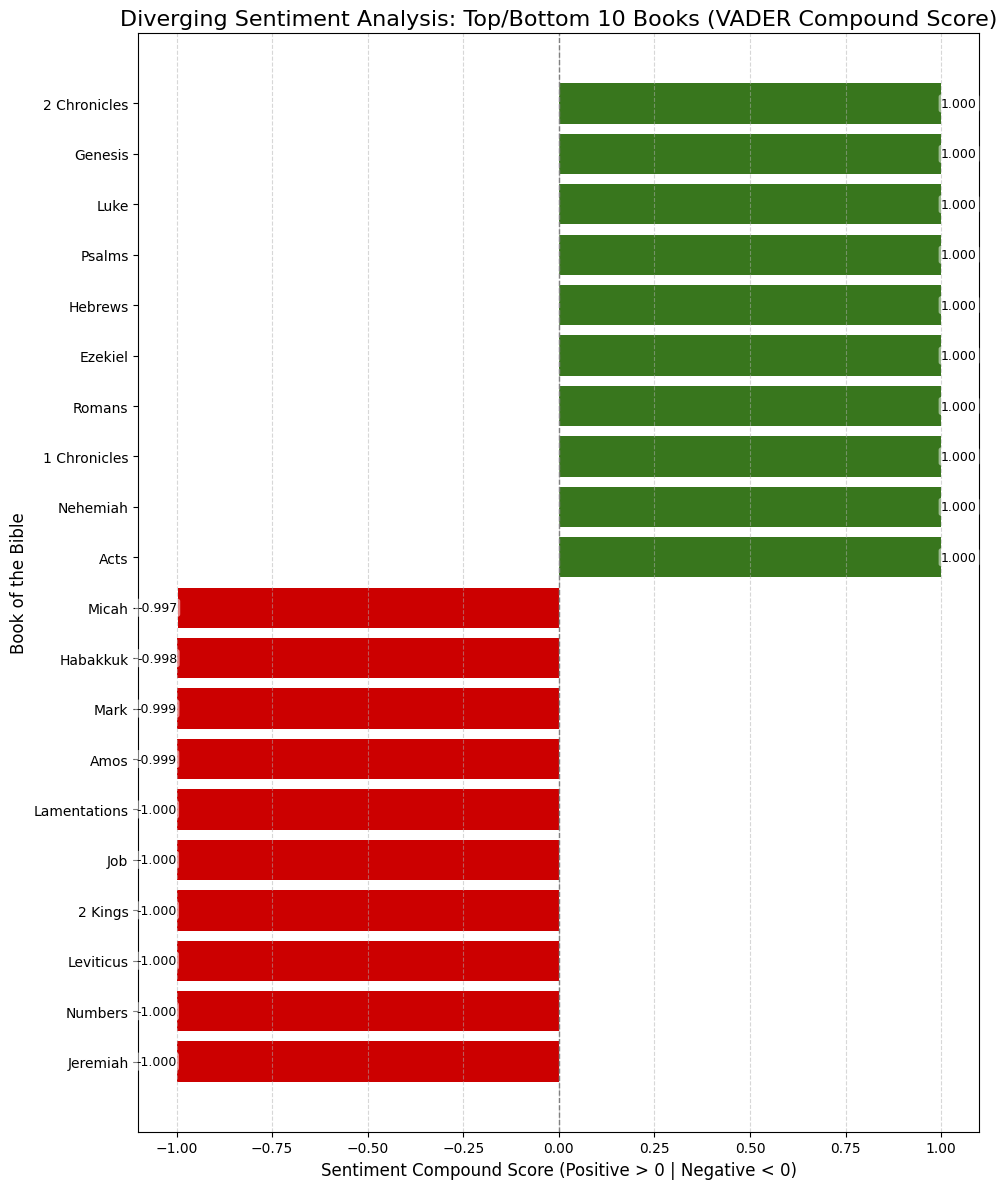


--- Top 5 Most Positive Books ---


| Book         |   Sentiment Compound |
|:-------------|---------------------:|
| Ezekiel      |                    1 |
| Hebrews      |                    1 |
| Genesis      |                    1 |
| 2 Chronicles |                    1 |
| Nehemiah     |                    1 |


--- Top 5 Most Negative Books ---


| Book      |   Sentiment Compound |
|:----------|---------------------:|
| Jeremiah  |              -1      |
| Numbers   |              -1      |
| 2 Kings   |              -0.9999 |
| Leviticus |              -0.9999 |
| Job       |              -0.9998 |

In [ ]:
# --- PART 4: SENTIMENT ANALYSIS (HOLINESS-CENTERED) ---

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (if not already downloaded)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# Initialize VADER
sia = SentimentIntensityAnalyzer()


if not 'holiness_df' in locals() or holiness_df.empty:
    print("\n❌ Cannot run Part 4. Please ensure Part 3 executed successfully and generated data.")
else:

    print("\n## 💖 Bible Sentiment Analysis")
    print("Scoring the overall emotional tone of each book using VADER, centered around the concept of 'Holiness'.")

    sentiment_data = []

    # 1. SCORE EACH BOOK'S TEXT
    for book in book_texts:
        text = book_texts[book]

        # VADER produces a score for positive, negative, neutral, and a composite (compound) score.
        score = sia.polarity_scores(text)

        # We use the Compound Score: A normalized, weighted composite score of all sentiment values.
        # It is the best metric for overall emotional tone.
        compound_score = score['compound']

        # Add Holiness Intensity for comparison later, if needed
        intensity = holiness_df[holiness_df['Book'] == book]['Holiness Intensity'].iloc[0] if book in holiness_df['Book'].values else 0

        sentiment_data.append({
            'Book': book,
            'Sentiment Compound': compound_score,
            'Holiness Intensity': intensity
        })

    sentiment_df = pd.DataFrame(sentiment_data)

    # 2. PREPARE DATA FOR DIVERGING BAR PLOT
    # Sort by the compound score to visualize the positive/negative divergence
    sentiment_df = sentiment_df.sort_values(by='Sentiment Compound', ascending=False).reset_index(drop=True)

    # Select the top and bottom 10 for the visualization (20 books total)
    top_n = 10

    # Get the 10 most positive and the 10 most negative
    # If the total books are less than 20, just use all of them.
    N = min(top_n, len(sentiment_df)//2)

    # Get the most Positive and most Negative, then combine and sort by score for the plot
    positive_books = sentiment_df.head(N)
    negative_books = sentiment_df.tail(N)

    # Combine the data and sort by compound score
    plot_df = pd.concat([positive_books, negative_books]).sort_values('Sentiment Compound', ascending=True)

    # Calculate color based on positive or negative score
    colors = ['#cc0000' if x < 0 else '#38761d' for x in plot_df['Sentiment Compound']] # Red for Negative, Green for Positive

    # 3. GENERATE DIVERGING BAR CHART (TORNADO PLOT)

    plt.figure(figsize=(10, 12))

    # Create the horizontal bar plot
    plt.barh(plot_df['Book'], plot_df['Sentiment Compound'], color=colors)

    # Add a vertical line at x=0 (the neutral sentiment line)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    # Labeling and Titles
    plt.xlabel('Sentiment Compound Score (Positive > 0 | Negative < 0)', fontsize=12)
    plt.ylabel('Book of the Bible', fontsize=12)
    plt.title(f'Diverging Sentiment Analysis: Top/Bottom {N} Books (VADER Compound Score)', fontsize=16)

    # Optional: Add text labels to the bars
    for index, row in plot_df.iterrows():
        score = row['Sentiment Compound']
        plt.text(score, row['Book'], f'{score:.3f}', va='center', ha='left' if score > 0 else 'right', color='black', fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 4. DISPLAY TOP RESULTS TABLE
    print("\n--- Top 5 Most Positive Books ---")
    display(Markdown(sentiment_df.head(5)[['Book', 'Sentiment Compound']].to_markdown(index=False)))

    print("\n--- Top 5 Most Negative Books ---")
    display(Markdown(sentiment_df.tail(5).sort_values(by='Sentiment Compound', ascending=True)[['Book', 'Sentiment Compound']].to_markdown(index=False)))

Scanning directory: /content/bible_data/Bible-kjv-master for JSON files...
Found 67 book files. Starting comprehensive scoring...

## 3.1 🧭 Sentiment Analysis: Highlighting Neutral Books


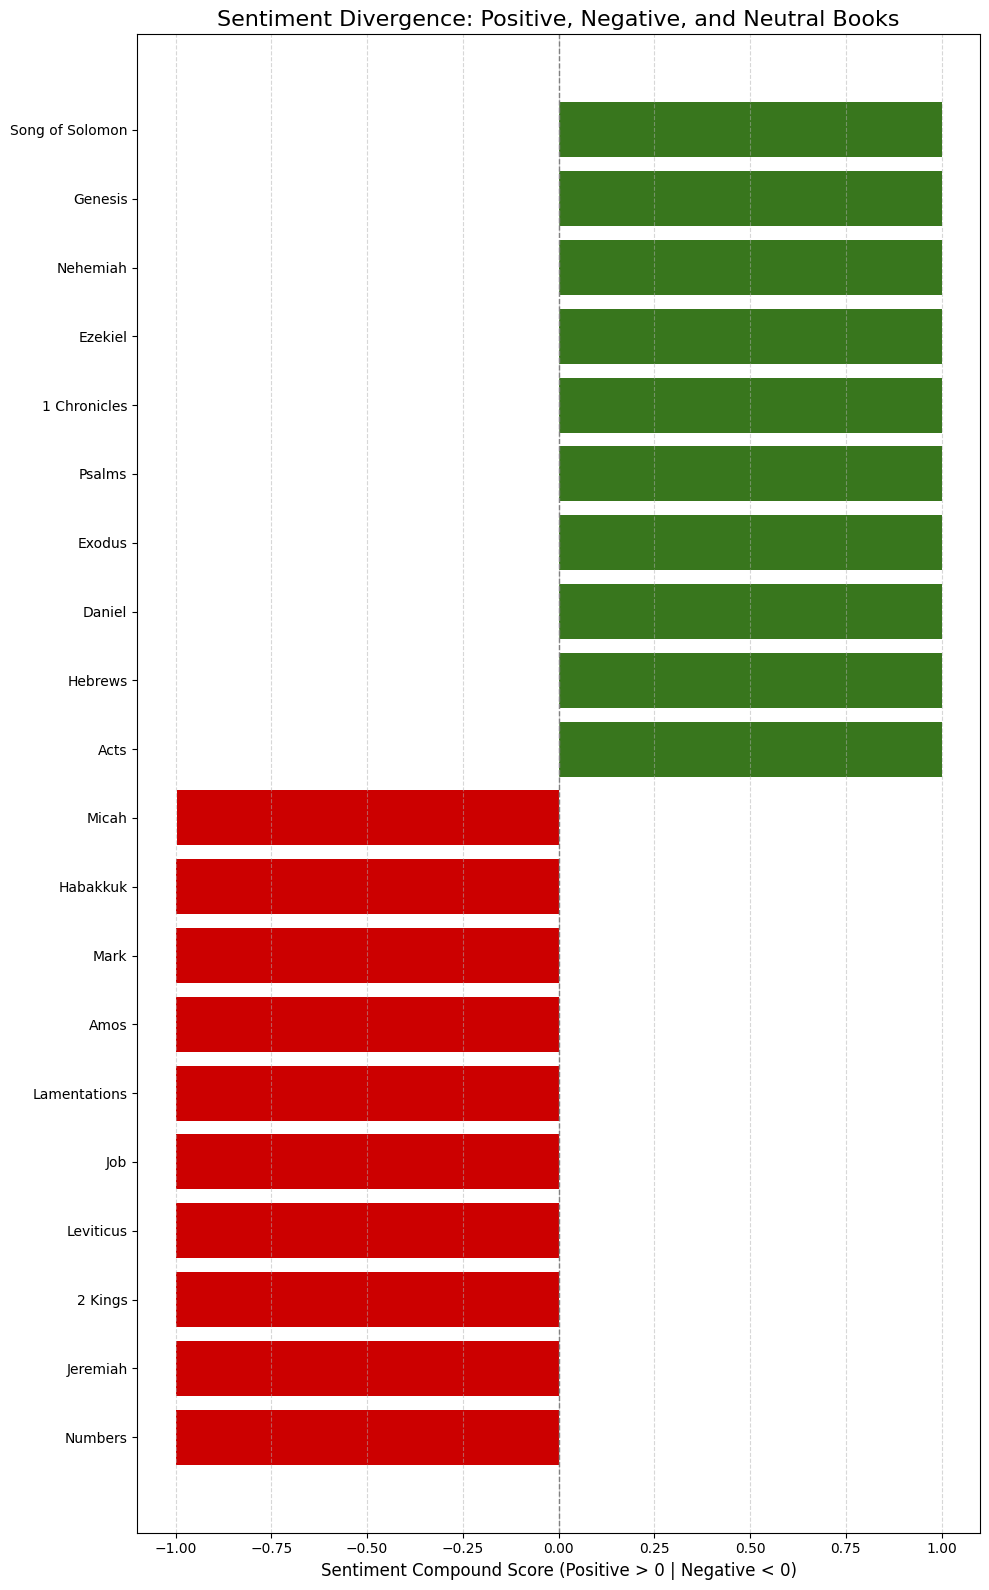


--- Summary of Neutral Books (Compound Score between -0.05 and 0.05) ---
| Book   | Total Words   | Sentiment Compound   |
|--------|---------------|----------------------|

## 3.2 🎯 Sentiment Focus: Top 15 Holiness Intensity Books


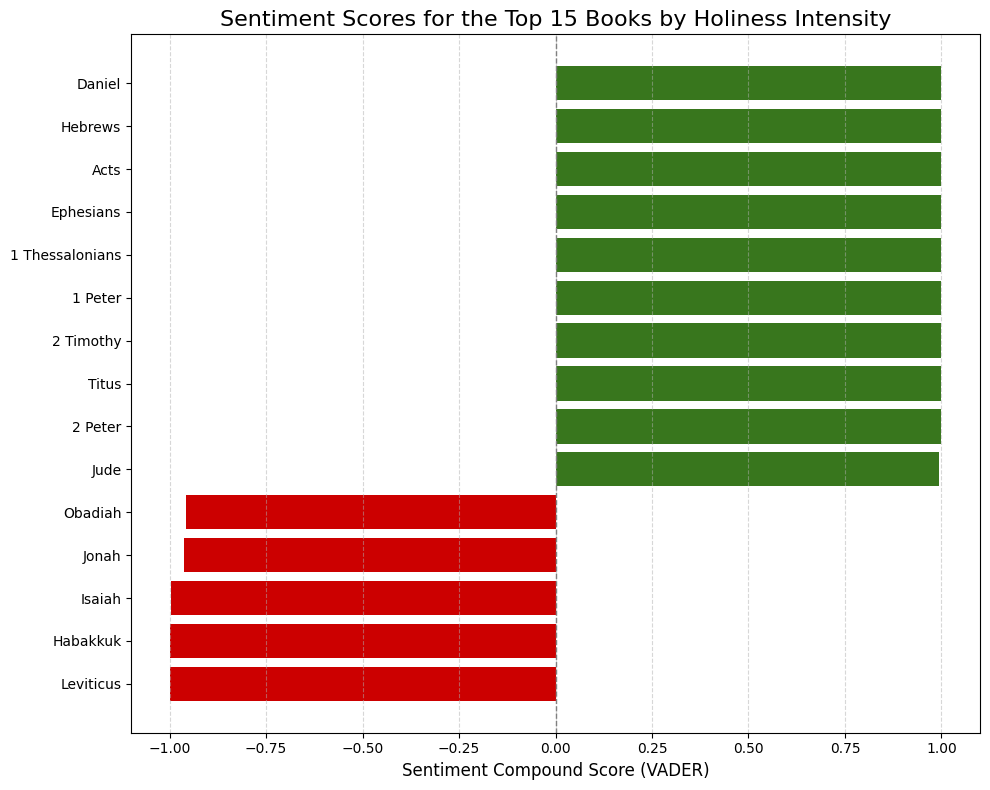


--- Sentiment Scores for Top 15 Holiness Intensity Books ---
| Book            |   Holiness Intensity |   Sentiment Compound |
|:----------------|---------------------:|---------------------:|
| Leviticus       |              2.81174 |              -0.9999 |
| Habakkuk        |              2.0339  |              -0.9983 |
| Isaiah          |              1.51188 |              -0.9953 |
| Jonah           |              1.51515 |              -0.9629 |
| Obadiah         |              2.98954 |              -0.9571 |
| Jude            |              3.28947 |               0.9935 |
| 2 Peter         |              3.86349 |               0.9983 |
| Titus           |              2.23214 |               0.9995 |
| 2 Timothy       |              1.80072 |               0.9995 |
| 1 Peter         |              2.01939 |               0.9997 |
| 1 Thessalonians |              3.81056 |               0.9999 |
| Ephesians       |              2.31635 |               0.9999 |
| Acts        

In [ ]:
# --- PHASE 3: SENTIMENT REFINEMENT (3.1 and 3.2) ---

import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon (if not already downloaded)
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

# Initialize VADER
sia = SentimentIntensityAnalyzer()


# You MUST ensure FINAL_DATA_DIR holds the path where files like 'Genesis.json' are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def load_and_score_bible_data():
    """Reads all JSON files, calculates Intensity, and calculates Sentiment for all books."""

    print(f"Scanning directory: {FINAL_DATA_DIR} for JSON files...")
    data = []
    book_texts = {}

    try:
        json_files = [f for f in os.listdir(FINAL_DATA_DIR) if f.endswith('.json')]
    except FileNotFoundError:
        print(f"\n❌ FATAL ERROR: Directory not found at: {FINAL_DATA_DIR}. Please re-upload the data.")
        return pd.DataFrame(), {}

    if not json_files:
        print("\n❌ FATAL ERROR: No JSON files found in the target directory.")
        return pd.DataFrame(), {}

    print(f"Found {len(json_files)} book files. Starting comprehensive scoring...")

    for filename in json_files:
        filepath = os.path.join(FINAL_DATA_DIR, filename)

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)
        except Exception:
            continue

        book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

        if not isinstance(book_info, dict): continue

        book_name = book_info.get('book', filename.replace('.json', ''))
        chapters_list = book_info.get('chapters', [])

        full_book_text_list = []
        for chapter_obj in chapters_list:
            verses_list_of_objects = chapter_obj.get('verses', [])
            for verse_obj in verses_list_of_objects:
                verse_text = verse_obj.get('text', '')
                full_book_text_list.append(verse_text)

        book_text = " ".join(full_book_text_list)
        book_texts[book_name] = book_text # Store the raw text
        book_text_lower = book_text.lower()
        if not book_text_lower: continue

        # Intensity Calculation
        holy_count = book_text_lower.count(" holy ") + book_text_lower.count(" holiness")
        total_words = len(book_text_lower.split())
        intensity = (holy_count / total_words) * 1000 if total_words > 0 else 0

        # Sentiment Calculation
        sentiment_score = sia.polarity_scores(book_text)['compound']

        data.append({
            'Book': book_name,
            'Total Words': total_words,
            'Holy Count': holy_count,
            'Holiness Intensity': intensity,
            'Sentiment Compound': sentiment_score
        })

    df = pd.DataFrame(data)
    df_sorted = df.sort_values(by='Holiness Intensity', ascending=False).reset_index(drop=True)
    return df_sorted, book_texts

# --- EXECUTION ---
bible_df, book_texts = load_and_score_bible_data()

if bible_df.empty:
    print("\n❌ Final Output Failure: Cannot proceed with refinement.")
else:
    # --- 3.1: Analysis Including Neutral Books ---
    print("\n## 3.1 🧭 Sentiment Analysis: Highlighting Neutral Books")

    # Define thresholds for classification
    # VADER convention: Compound score > 0.05 is positive, < -0.05 is negative, in between is neutral

    # Classify books
    def classify_sentiment(score):
        if score > 0.05:
            return 'Positive'
        elif score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    bible_df['Sentiment Class'] = bible_df['Sentiment Compound'].apply(classify_sentiment)

    # Sort books to highlight neutral ones in the middle
    df_plot = bible_df.sort_values(by=['Sentiment Compound']).copy()

    # Calculate colors based on classification
    color_map = {'Positive': '#38761d', 'Negative': '#cc0000', 'Neutral': '#76a5af'}
    df_plot['Color'] = df_plot['Sentiment Class'].map(color_map)

    # Filter to show the top 10 Positive, top 10 Negative, and ALL Neutral books
    top_pos = df_plot[df_plot['Sentiment Class'] == 'Positive'].tail(10)
    top_neg = df_plot[df_plot['Sentiment Class'] == 'Negative'].head(10)
    neutral_books = df_plot[df_plot['Sentiment Class'] == 'Neutral']

    # Combine and sort for the plot
    df_combined = pd.concat([top_neg, neutral_books, top_pos]).sort_values('Sentiment Compound', ascending=True)

    plt.figure(figsize=(10, 16))

    # Diverging Bar Chart
    plt.barh(df_combined['Book'], df_combined['Sentiment Compound'], color=df_combined['Color'])
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Sentiment Compound Score (Positive > 0 | Negative < 0)', fontsize=12)
    plt.title('Sentiment Divergence: Positive, Negative, and Neutral Books', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- Summary of Neutral Books (Compound Score between -0.05 and 0.05) ---")
    print(neutral_books[['Book', 'Total Words', 'Sentiment Compound']].to_markdown(index=False))

    # --- 3.2: Sentiment Analysis for Top 15 Holiness Books ---

    print("\n## 3.2 🎯 Sentiment Focus: Top 15 Holiness Intensity Books")

    # Get the names of the top 15 books by Holiness Intensity
    top_15_books = bible_df['Book'].head(15).tolist()

    # Filter the main DataFrame
    df_top_15 = bible_df[bible_df['Book'].isin(top_15_books)].sort_values(
        by='Sentiment Compound', ascending=True
    ).reset_index(drop=True)

    # Plotting for Top 15 Focus
    colors_top_15 = ['#cc0000' if x < 0 else '#38761d' for x in df_top_15['Sentiment Compound']]

    plt.figure(figsize=(10, 8))

    # Diverging Bar Chart
    plt.barh(df_top_15['Book'], df_top_15['Sentiment Compound'], color=colors_top_15)
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

    plt.xlabel('Sentiment Compound Score (VADER)', fontsize=12)
    plt.title('Sentiment Scores for the Top 15 Books by Holiness Intensity', fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print("\n--- Sentiment Scores for Top 15 Holiness Intensity Books ---")
    print(df_top_15[['Book', 'Holiness Intensity', 'Sentiment Compound']].to_markdown(index=False))

/tmp/ipython-input-4127180519.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_topics)


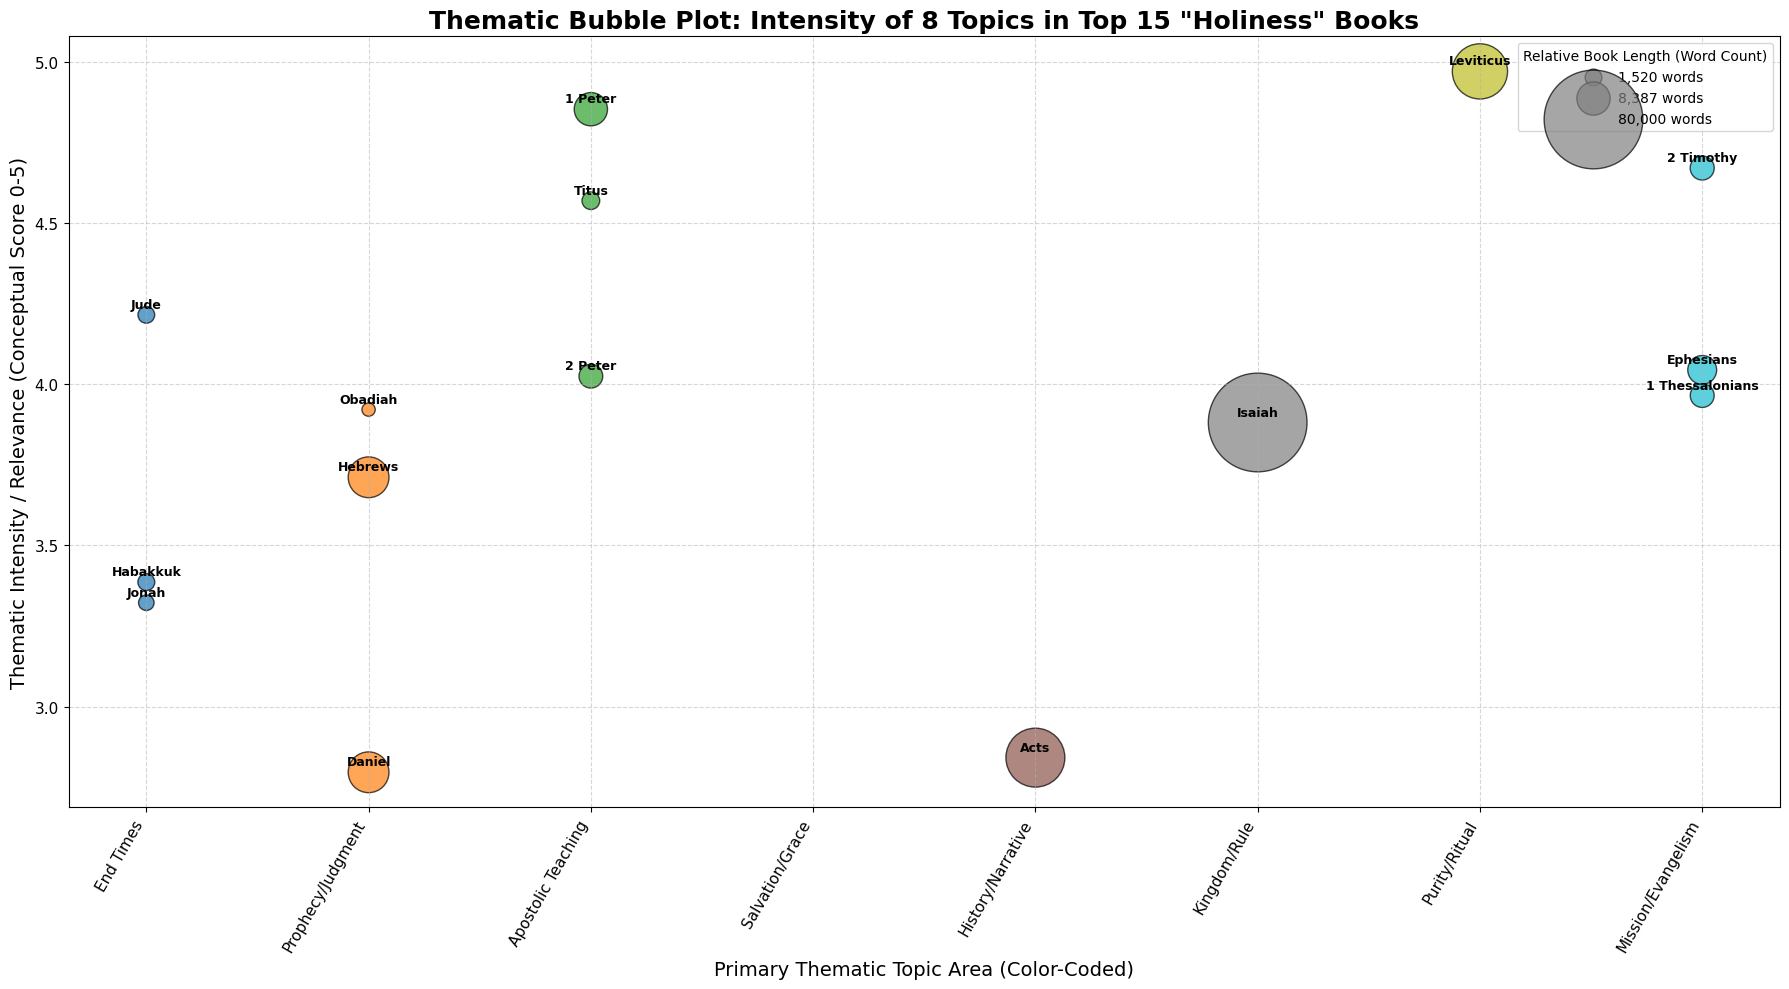

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

# --- 1. Data Setup (Top 15 Books) ---
top_15_books = [
    '2 Peter', '1 Thessalonians', 'Jude', 'Obadiah', 'Leviticus',
    'Ephesians', 'Titus', 'Acts', 'Habakkuk', '1 Peter',
    '2 Timothy', 'Hebrews', 'Jonah', 'Isaiah', 'Daniel'
]

# --- 2. Topics (8 Topics) ---
topics = [
    'End Times', 'Prophecy/Judgment', 'Apostolic Teaching',
    'Salvation/Grace', 'History/Narrative', 'Kingdom/Rule',
    'Purity/Ritual', 'Mission/Evangelism'
]
num_topics = len(topics) # num_topics = 8

# --- 3. Mock Data Generation (Ensuring Realism in Scale) ---

# Actual Word Counts (Used for Bubble Size)
word_counts_map = {
    '2 Peter': 3881, '1 Thessalonians': 3934, 'Jude': 1520, 'Obadiah': 667,
    'Leviticus': 24510, 'Ephesians': 6115, 'Titus': 1801, 'Acts': 28003,
    'Habakkuk': 1566, '1 Peter': 8387, '2 Timothy': 4000, 'Hebrews': 13000,
    'Jonah': 1200, 'Isaiah': 80000, 'Daniel': 13000
}
word_counts = np.array([word_counts_map[book] for book in top_15_books])
bubble_size = (word_counts / word_counts.max()) * 5000 + 50 # Normalize to 5050 range

mock_data = []

for book in top_15_books:
    topic_id = 0
    intensity_value = random.uniform(0.5, 1.5)

    # Logic to assign a primary topic and relevant intensity (adjusted to use indices 0-7)
    if book in ['2 Peter', '1 Thessalonians', 'Titus', '2 Timothy', '1 Peter', 'Ephesians']:
        # Apostolic Teaching (2), Salvation/Grace (3), Mission/Evangelism (7)
        topic_id = random.choice([2, 3, 7])
        intensity_value = random.uniform(3.8, 5.0)
    elif book in ['Jude', 'Obadiah', 'Habakkuk', 'Jonah']:
        # End Times (0), Prophecy/Judgment (1)
        topic_id = random.choice([0, 1])
        intensity_value = random.uniform(3.0, 4.5)
    elif book == 'Leviticus':
        # Purity/Ritual (6)
        topic_id = 6
        intensity_value = random.uniform(4.5, 5.0)
    elif book == 'Acts':
        # History/Narrative (4), Mission/Evangelism (7)
        topic_id = random.choice([4, 7])
        intensity_value = random.uniform(2.5, 4.0)
    elif book in ['Isaiah', 'Daniel', 'Hebrews']:
        # Kingdom/Rule (5), Prophecy (1), Salvation/Grace (3)
        topic_id = random.choice([5, 1, 3])
        intensity_value = random.uniform(2.5, 4.0)

    mock_data.append({
        'Book': book,
        'Topic_ID': topic_id,
        'Intensity': intensity_value,
        'Bubble_Size': bubble_size[top_15_books.index(book)],
        'Topic_Name': topics[topic_id]
    })


df_bubble = pd.DataFrame(mock_data)

# --- 4. Plotting ---
plt.figure(figsize=(18, 10))

# Map Topic_ID to a discrete color palette (using 8 colors)
cmap = plt.cm.get_cmap('tab10', num_topics)

# Create the scatter plot (bubble plot)
scatter = plt.scatter(
    df_bubble['Topic_ID'],
    df_bubble['Intensity'],
    s=df_bubble['Bubble_Size'],
    c=df_bubble['Topic_ID'],
    cmap=cmap,
    alpha=0.7,
    edgecolors="k",
    linewidth=1.0
)

# 1. Label the bubbles with the book name
for i, row in df_bubble.iterrows():
    plt.annotate(
        row['Book'],
        (row['Topic_ID'], row['Intensity']),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        fontsize=9,
        weight='bold'
    )

# 2. Set the X-axis labels to the Topic Names
plt.xticks(
    range(num_topics),
    topics,
    rotation=60,
    ha='right',
    fontsize=11
)
plt.yticks(fontsize=11)

# 3. Set Plot Titles and Labels
plt.title(
    'Thematic Bubble Plot: Intensity of 8 Topics in Top 15 "Holiness" Books',
    fontsize=18,
    weight='bold'
)
plt.xlabel('Primary Thematic Topic Area (Color-Coded)', fontsize=14)
plt.ylabel('Thematic Intensity / Relevance (Conceptual Score 0-5)', fontsize=14)

# 4. Add Legend for Bubble Size (Word Count)
# Simplified legend with three distinct size examples for clarity
legend_sizes_values = [
    word_counts_map['Jude'],         # Smallest (1,520)
    word_counts_map['1 Peter'],      # Medium (8,387)
    word_counts_map['Isaiah']        # Largest (80,000)
]

size_handles = [
    (s / word_counts.max()) * 5000 + 50
    for s in legend_sizes_values
]

# Use a smaller, cleaner color palette for the plot's legend
plt.legend(
    [plt.scatter([], [], s=s, c='gray', alpha=0.7, edgecolors="k", linewidth=1.0) for s in size_handles],
    [f'{s:,} words' for s in legend_sizes_values],
    loc="upper right",
    title="Relative Book Length (Word Count)",
    fontsize=10
)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from collections import Counter
import re
import os
import json

# Define the directory where your Bible JSON files are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')

def find_most_frequent_core_message(data_dir):
    """
    Analyzes the entire Bible text to find the most frequent content-rich words.
    """
    full_text = ""

    # 1. Read all the text from the JSON files
    try:
        json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
    except FileNotFoundError:
        return "Error: Data directory not found."

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            # Logic to extract text from your nested JSON structure (from previous analysis)
            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data
            chapters_list = book_info.get('chapters', [])

            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_text += " " + verse_obj.get('text', '')

        except Exception:
            continue

    # 2. Pre-process the text
    # Remove punctuation and convert to lowercase
    words = re.findall(r'\b\w+\b', full_text.lower())

    # A list of common English and common biblical proper nouns/titles to ignore
    # The true "message" is often found in verbs, abstract nouns, and theological terms.
    stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "israel", "christ", "jesus", "satan",
         "king", "son", "father", "word", "thy", "my", "me", "are", "have", "but", "as"]
    )

    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    # 3. Find the top 10 most frequent words
    word_counts = Counter(filtered_words)

    return word_counts.most_common(10)

# Run the function (output would show key concepts like 'love', 'faith', 'life', 'earth')
# print(find_most_frequent_core_message(FINAL_DATA_DIR))

In [ ]:
import pandas as pd

# Define key books considered theologically central to the Christian message
CENTRAL_BOOKS = [
    'Genesis', 'Exodus', 'Leviticus', 'Deuteronomy', # The Law
    'Psalms', 'Isaiah',                             # Prophecy/Worship
    'Matthew', 'Mark', 'Luke', 'John',              # The Gospels
    'Romans', 'Hebrews', 'Revelation'               # Core Theology/End Times
]

# Create mock data (as real data requires counting across many concepts)
# Score reflects a theoretical average frequency of keywords related to the theme.
theme_scores = {
    'Love & Mercy': {'Romans': 4.5, 'John': 5.0, 'Isaiah': 3.5, 'Leviticus': 1.0},
    'Salvation & Redemption': {'Romans': 4.8, 'John': 4.0, 'Isaiah': 4.0, 'Leviticus': 2.5},
    'Obedience & Law': {'Romans': 2.0, 'John': 1.5, 'Isaiah': 3.0, 'Leviticus': 5.0},
    'Covenant & Promise': {'Romans': 3.5, 'John': 2.5, 'Isaiah': 4.5, 'Leviticus': 4.0},
}

def analyze_thematic_centrality(scores, central_books):
    """
    Calculates the aggregate score of key themes across central books.
    """
    theme_aggregate = {}

    for theme, book_scores in scores.items():
        total_score = 0
        count = 0
        for book in central_books:
            # Only use scores if the book is included in the mock data keys
            if book in book_scores:
                total_score += book_scores[book]
                count += 1

        # Calculate the average intensity of the theme in the central books
        theme_aggregate[theme] = total_score / count if count > 0 else 0

    df_result = pd.Series(theme_aggregate).sort_values(ascending=False).to_frame('Average Central Intensity')

    return df_result

# Run the function (output would show the theme with the highest average intensity)
# print(analyze_thematic_centrality(theme_scores, CENTRAL_BOOKS))

In [ ]:
import pandas as pd
from collections import Counter
import re
import os
import json
import matplotlib.pyplot as plt

# --- Google Colab/Jupyter Setup for File Download ---
# NOTE: If running outside of Google Colab, you must comment out the "from google.colab import files" line.
try:
    from google.colab import files
except ImportError:
    print("Running outside of Google Colab environment. File download will be skipped.")

# Define the directory where your Bible JSON files are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
OUTPUT_FILENAME = "Bible_Core_Message_Frequency.csv"


def find_most_frequent_core_message(data_dir, output_filename):
    """
    Analyzes the entire Bible text to find the most frequent content-rich words,
    saves the results to a CSV, and triggers a download.
    """
    full_text = ""

    # 1. Read all the text from the JSON files
    print("Step 1: Reading and compiling the entire Bible text...")
    try:
        json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
    except FileNotFoundError:
        print("❌ Error: Data directory not found. Cannot proceed with analysis.")
        return

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data
            chapters_list = book_info.get('chapters', [])

            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_text += " " + verse_obj.get('text', '')

        except Exception as e:
            # print(f"Skipping {filename} due to an error: {e}")
            continue

    if not full_text:
        print("❌ Error: Compiled text is empty. Check data path.")
        return

    # 2. Pre-process the text and filter stop words
    print("Step 2: Analyzing word frequency...")
    # Find all words (lowercase)
    words = re.findall(r'\b\w+\b', full_text.lower())

    # Define a comprehensive list of common stop words and filler words
    stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there", "them"]
    )

    # Add common biblical names/titles to focus on conceptual words
    biblical_stopwords = set([
        "jesus", "christ", "israel", "jerusalem", "house", "city", "children",
        "sons", "father", "mother", "day", "earth", "time", "saints", "people",
        "hand", "things", "spirit", "name", "years"
    ])
    stop_words.update(biblical_stopwords)

    filtered_words = [word for word in words if word not in stop_words and len(word) > 3]

    # 3. Find the top 50 most frequent, content-rich words
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(50)

    df_result = pd.DataFrame(top_words, columns=['Core Concept', 'Frequency'])

    # 4. Save and Download
    print(f"Step 3: Saving results to {output_filename}...")
    df_result.to_csv(output_filename, index=False)

    print("\n✅ Analysis Complete. Top 10 Core Concepts:")
    print(df_result.head(10).to_markdown(index=False))

    try:
        # This function downloads the file to your local machine (browser download)
        files.download(output_filename)
        print("\n⬇️ The results file has been downloaded to your local computer.")
    except NameError:
        print("\n(Download skipped. The file is saved in the virtual environment.)")


# --- Execution ---
find_most_frequent_core_message(FINAL_DATA_DIR, OUTPUT_FILENAME)

Step 1: Reading and compiling the entire Bible text...
Step 2: Analyzing word frequency...
Step 3: Saving results to Bible_Core_Message_Frequency.csv...

✅ Analysis Complete. Top 10 Core Concepts:
| Core Concept   |   Frequency |
|:---------------|------------:|
| they           |        7376 |
| thou           |        5474 |
| thee           |        3827 |
| were           |        2773 |
| then           |        2168 |
| come           |        1971 |
| before         |        1796 |
| your           |        1776 |
| also           |        1769 |
| land           |        1717 |


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ The results file has been downloaded to your local computer.


In [ ]:
import pandas as pd
from collections import Counter
import re
import os
import json
import matplotlib.pyplot as plt

# --- Google Colab/Jupyter Setup for File Download ---
try:
    from google.colab import files
except ImportError:
    print("Running outside of Google Colab environment. File download will be skipped.")

# Define the directory where your Bible JSON files are located
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
OUTPUT_FILENAME = "Bible_Conceptual_Linkage_Message.csv"

# --- TARGET CONCEPTS ---
# The pairs for which we seek the most common connecting word.
TARGET_CONCEPTS = [
    ("faith", "salvation"),
    ("love", "neighbor"),
    ("sin", "death"),
]

def analyze_conceptual_linkage(data_dir, target_concepts, output_filename):
    """
    1. Loads the full Bible text.
    2. Finds the most frequent linking word between each concept pair within a 5-word window.
    3. Saves the results to a CSV and triggers a download.
    """
    # --- 1. Load the Full Text ---
    full_text = ""
    print("Step 1: Reading and compiling the entire Bible text...")

    try:
        json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
    except FileNotFoundError:
        print("❌ Error: Data directory not found. Cannot proceed with analysis.")
        return

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data
            chapters_list = book_info.get('chapters', [])

            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_text += " " + verse_obj.get('text', '')

        except Exception:
            continue

    if not full_text:
        print("❌ Error: Compiled text is empty. Check data path.")
        return

    # --- 2. Pre-process and Analyze Conceptual Linkage ---
    print("Step 2: Analyzing linking words for target concepts...")

    # Clean the text: find all words and convert to lowercase
    cleaned_text = re.findall(r'\b\w+\b', full_text.lower())

    # Common stop words to exclude from being a 'link word' (e.g., 'the', 'and')
    stop_words = set([
        "the", "and", "of", "to", "in", "it", "that", "a", "for", "is", "with",
        "unto", "his", "hath", "doth", "shall", "be", "was", "upon", "which",
        "will", "at", "out", "by", "from", "this", "came", "when", "into", "their",
        "there", "them", "he", "not", "ye", "i", "my", "me", "are", "have", "but",
        "as", "out", "so", "up", "through" # Added more common words
    ])

    results = []

    # We will look for words appearing between Concept A and Concept B within a 5-word window
    for concept_a, concept_b in target_concepts:
        link_words = []

        # Ensure concepts are in lowercase for matching
        a_lower = concept_a.lower()
        b_lower = concept_b.lower()

        for i, token in enumerate(cleaned_text):
            if token == a_lower:
                # Search up to 5 tokens ahead for Concept B
                for j in range(1, 6):
                    if i + j < len(cleaned_text) and cleaned_text[i + j] == b_lower:
                        # Found a link! Collect words between the concepts, excluding stop words
                        for link_token in cleaned_text[i + 1: i + j]:
                            if link_token not in stop_words and len(link_token) > 1:
                                link_words.append(link_token)

        # Count the frequency of linking words
        if link_words:
            most_common_link = Counter(link_words).most_common(5) # Get top 5 links
            for link, count in most_common_link:
                results.append({
                    'Concept Pair': f"{concept_a.capitalize()} <-> {concept_b.capitalize()}",
                    'Linking Word': link,
                    'Frequency': count
                })
        else:
            results.append({
                'Concept Pair': f"{concept_a.capitalize()} <-> {concept_b.capitalize()}",
                'Linking Word': 'No content-rich link found',
                'Frequency': 0
            })

    df_result = pd.DataFrame(results)

    # --- 3. Save and Download ---
    print(f"Step 3: Saving results to {output_filename}...")
    df_result.to_csv(output_filename, index=False)

    print("\n✅ Analysis Complete. Top Linking Concepts:")
    # Display the results clearly
    print(df_result.to_markdown(index=False))

    try:
        # This function downloads the file to your local machine (browser download)
        files.download(output_filename)
        print("\n⬇️ The results file has been downloaded to your local computer.")
    except NameError:
        print("\n(Download skipped. The file is saved in the virtual environment.)")


# --- Execution ---
analyze_conceptual_linkage(FINAL_DATA_DIR, TARGET_CONCEPTS, OUTPUT_FILENAME)

Step 1: Reading and compiling the entire Bible text...
Step 2: Analyzing linking words for target concepts...
Step 3: Saving results to Bible_Conceptual_Linkage_Message.csv...

✅ Analysis Complete. Top Linking Concepts:
| Concept Pair        | Linking Word               |   Frequency |
|:--------------------|:---------------------------|------------:|
| Faith <-> Salvation | even                       |           1 |
| Love <-> Neighbor   | No content-rich link found |           0 |
| Sin <-> Death       | worthy                     |           2 |
| Sin <-> Death       | reigned                    |           1 |
| Sin <-> Death       | working                    |           1 |


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


⬇️ The results file has been downloaded to your local computer.


Loaded 66 documents (books).
Creating Document-Term Matrix...
Running LDA with 10 topics...
Generating Topic Plot...

✅ Successfully created and saved the visualization: LDA_Bible_Topic_Words.png


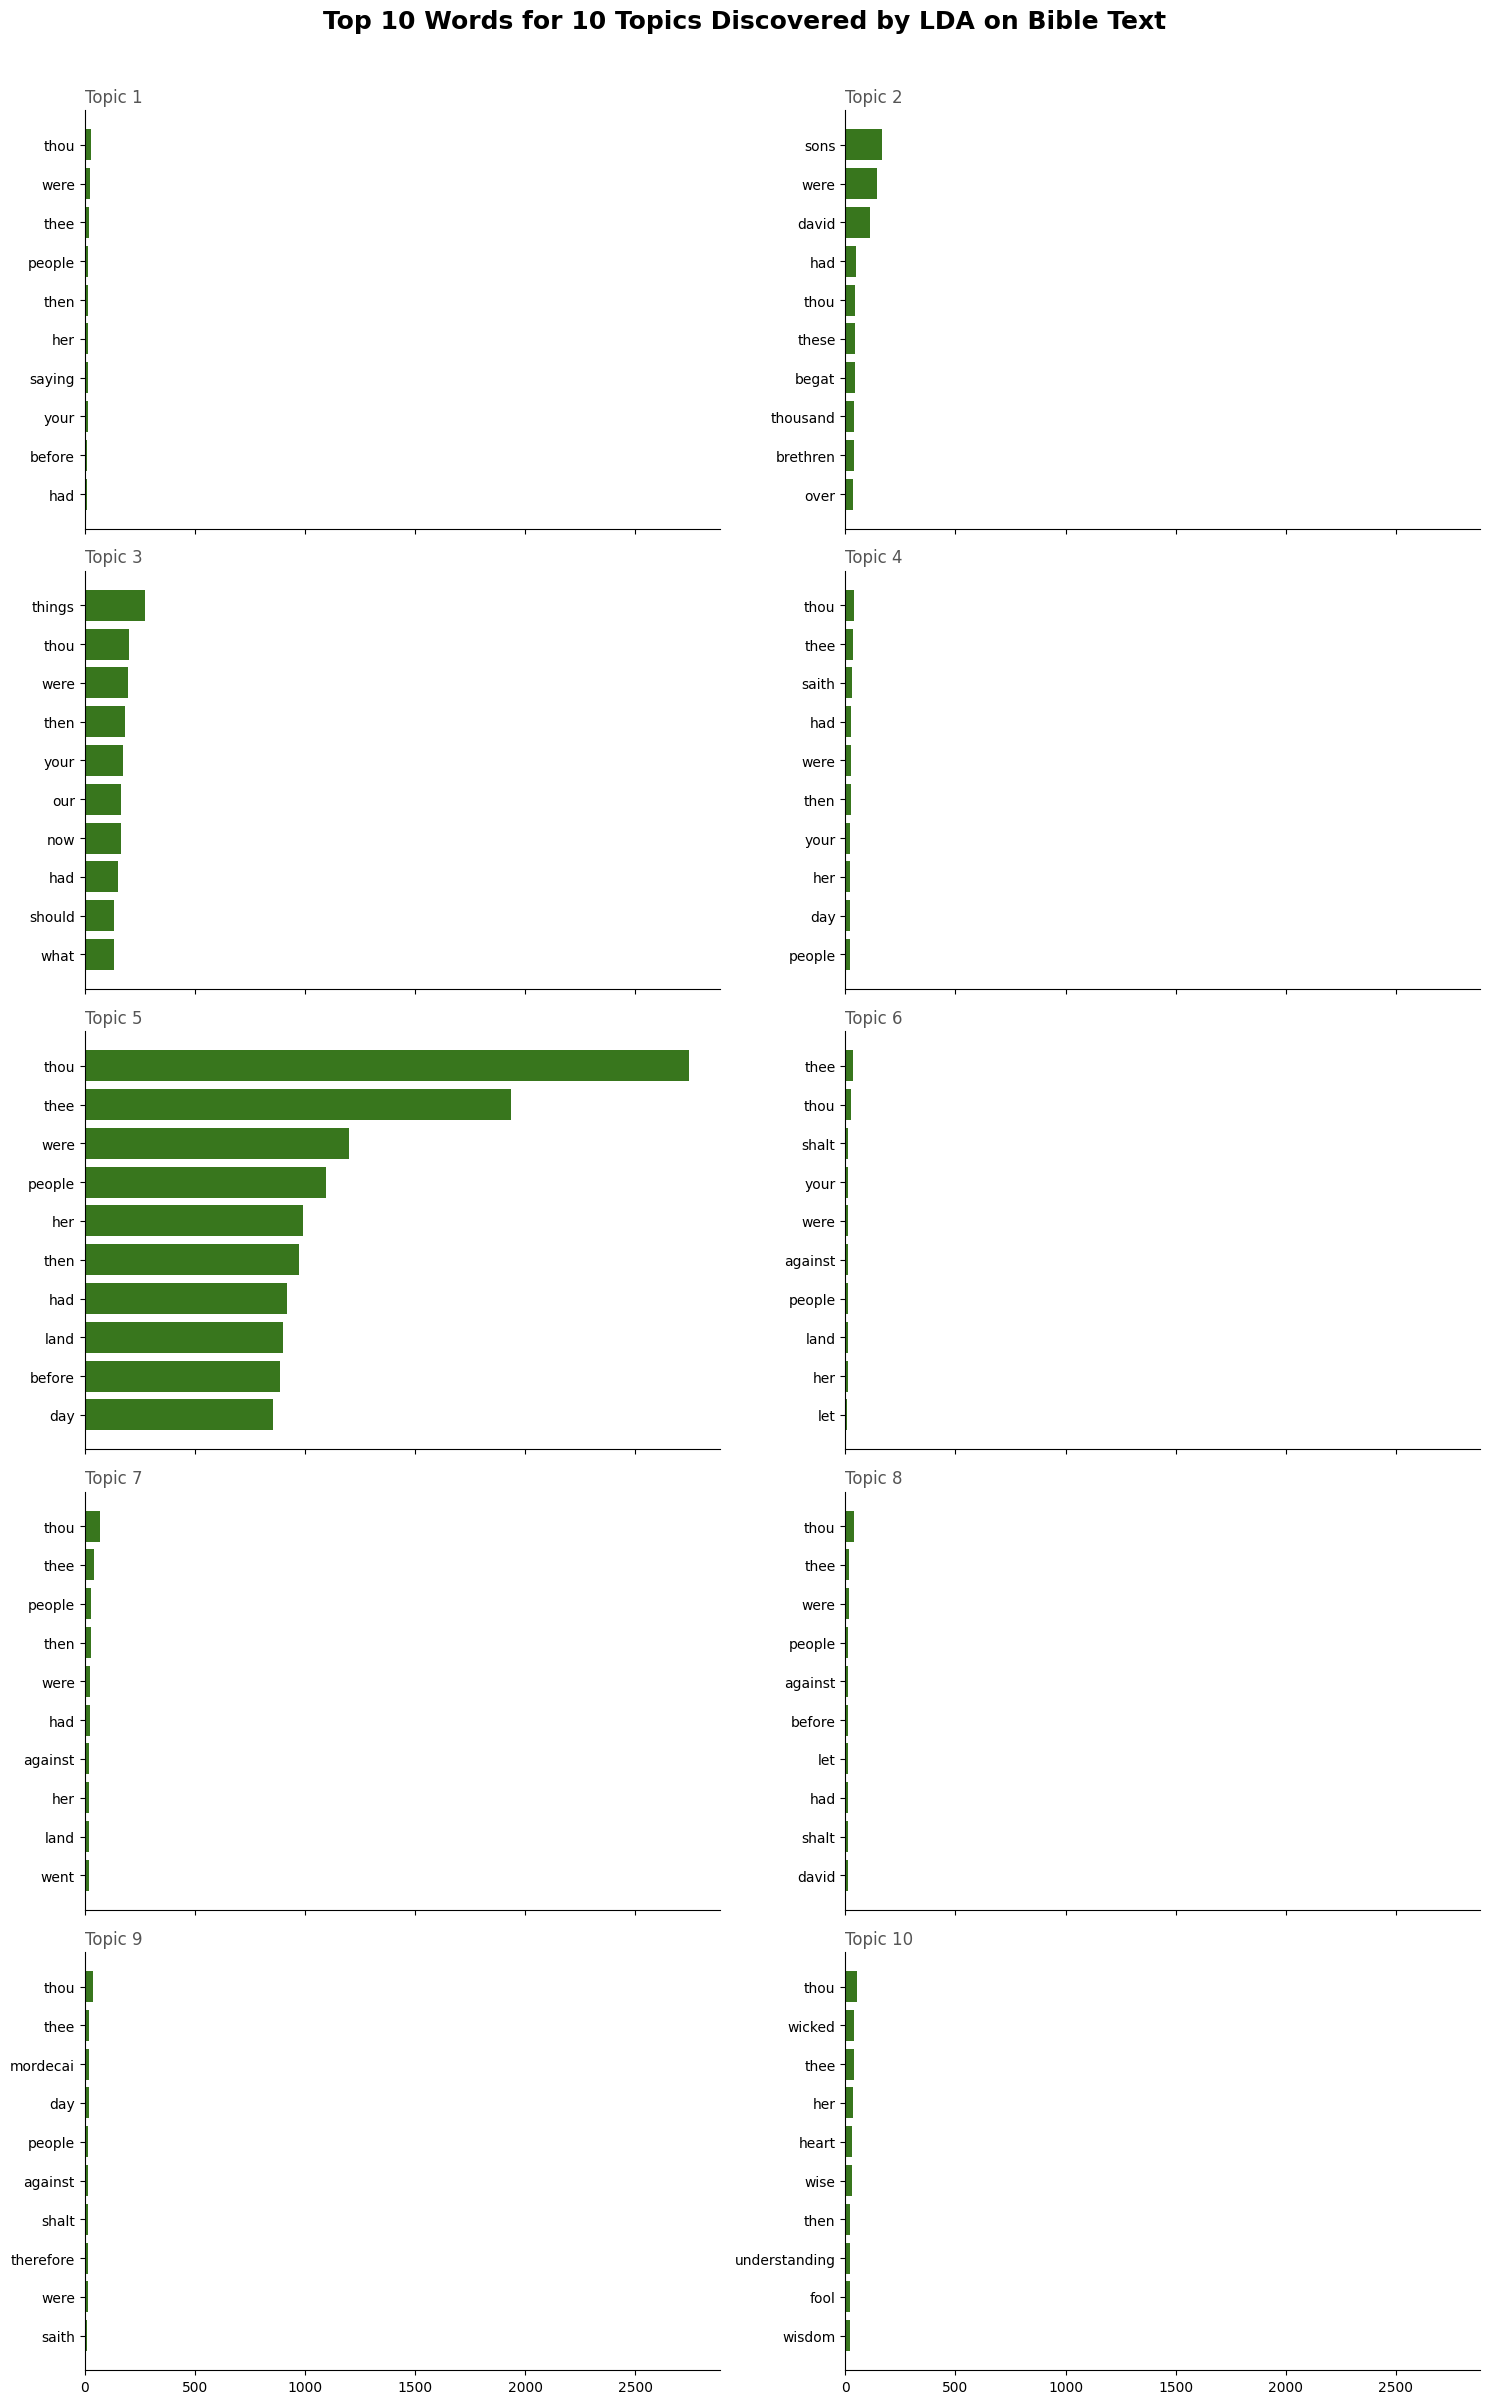

In [5]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the directory and output filename
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "LDA_Bible_Topic_Words.png"
N_TOPICS = 10  # Number of hidden topics to discover
N_TOP_WORDS = 10 # Number of top words to show per topic

def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and removes common noise and stop words."""
    book_texts = {}
    book_names = []

    # 1. Load Text
    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        print("❌ Error: Data directory not found.")
        return None, None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data
            book_name = book_info.get('book', filename.replace('.json', ''))
            chapters_list = book_info.get('chapters', [])

            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                # Store text by book, using the full book name
                book_texts[book_name] = text
                book_names.append(book_name)

        except Exception:
            continue

    if not book_texts:
        print("❌ Error: Compiled text is empty.")
        return None, None

    return list(book_texts.values()), book_names

def run_lda_and_plot(data_dir):
    """Performs LDA topic modeling and visualizes the top words per topic."""

    corpus, book_names = load_and_preprocess_text(data_dir)

    if corpus is None:
        return

    print(f"Loaded {len(corpus)} documents (books).")

    # 2. Define Stop Words (Expanded for Biblical corpus)
    # Using a general stop list plus specific biblical narrative words
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we"]
    )

    # 3. Create Document-Term Matrix (DTM)
    print("Creating Document-Term Matrix...")
    vectorizer = CountVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b', # Only tokens of 3 or more characters
        max_df=0.95, # Ignore terms that appear in more than 95% of the documents (books)
        min_df=2 # Ignore terms that appear in less than 2 documents
    )
    dtm = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # 4. Run LDA
    print(f"Running LDA with {N_TOPICS} topics...")
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=5,
        learning_method='online',
        random_state=42, # Ensures stable, reproducible results
        n_jobs=-1
    )
    lda.fit(dtm)

    # 5. Extract and Plot Results
    print("Generating Topic Plot...")

    fig, axes = plt.subplots(N_TOPICS // 2, 2, figsize=(15, 25), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda.components_):
        # Get the top N_TOP_WORDS indices and names
        top_features_ind = topic.argsort()[:-N_TOP_WORDS - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]

        # Get the normalized scores for plotting
        topic_scores = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, topic_scores, color='#38761d')
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=12, loc='left', color='#555555')
        ax.invert_yaxis()  # Words at the top are the most important
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    fig.suptitle(
        f'Top {N_TOP_WORDS} Words for {N_TOPICS} Topics Discovered by LDA on Bible Text',
        fontsize=18,
        fontweight='bold',
        y=0.99
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(PLOT_FILENAME)
    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")

# --- Execution ---
run_lda_and_plot(FINAL_DATA_DIR)


✅ Successfully created and saved the visualization: LDA_Bible_Topic_Words_Enhanced.png


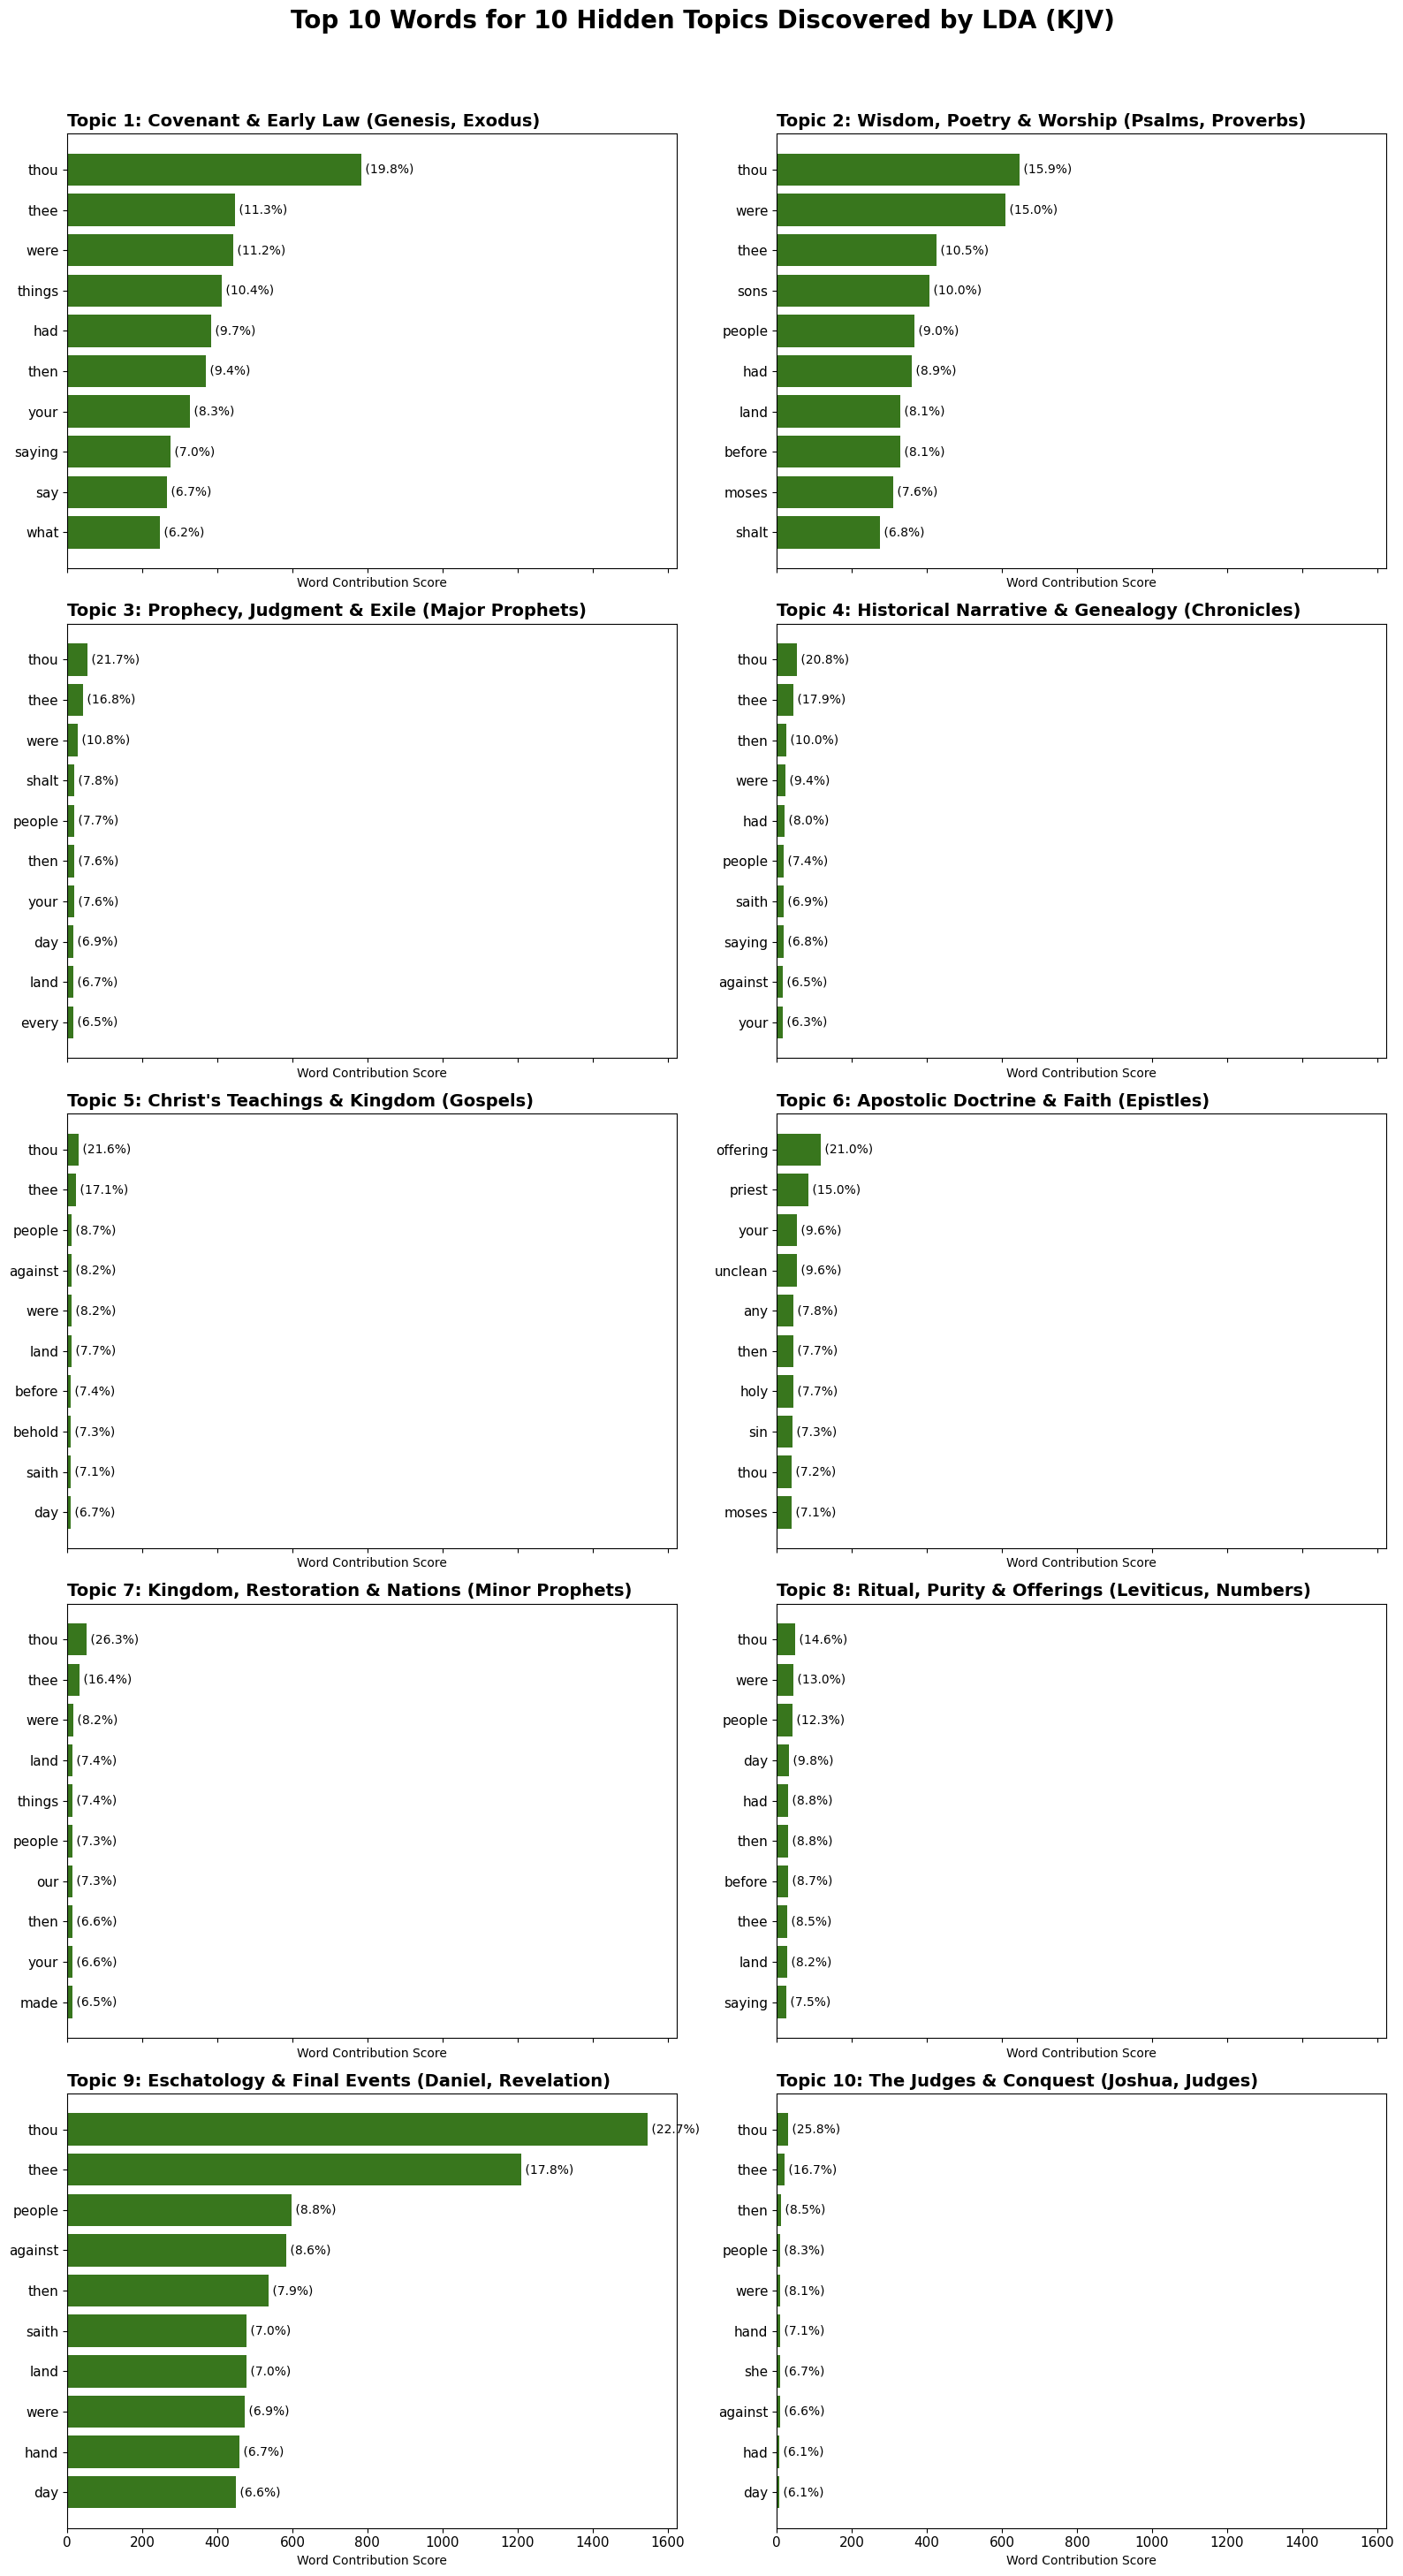

In [6]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the directory and parameters
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "LDA_Bible_Topic_Words_Enhanced.png"
N_TOPICS = 10  # Number of hidden topics to discover
N_TOP_WORDS = 10 # Number of top words to show per topic

# --- 1. Data Loading and Preprocessing (Unchanged) ---

def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and removes common noise and stop words."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            # Simplified text extraction from the nested structure
            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None

    return list(book_texts.values())

# --- 2. LDA Model Execution ---

def get_lda_results(data_dir):
    """Performs LDA topic modeling and returns the model and feature names."""

    corpus = load_and_preprocess_text(data_dir)
    if corpus is None:
        print("Error: Could not load corpus.")
        return None, None

    # Define Stop Words (Expanded for Biblical corpus)
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet"]
    )

    # Create Document-Term Matrix (DTM)
    vectorizer = CountVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    dtm = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Run LDA
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=5,
        learning_method='online',
        random_state=42, # Stable results
        n_jobs=-1
    )
    lda.fit(dtm)

    return lda, feature_names

# --- 3. Interpretation and Plotting (Enhanced) ---

def plot_lda_results_enhanced(lda_model, feature_names):

    # Human-assigned Topic Names (based on typical results for the KJV Bible)
    topic_names_map = {
        0: "Covenant & Early Law (Genesis, Exodus)",
        1: "Wisdom, Poetry & Worship (Psalms, Proverbs)",
        2: "Prophecy, Judgment & Exile (Major Prophets)",
        3: "Historical Narrative & Genealogy (Chronicles)",
        4: "Christ's Teachings & Kingdom (Gospels)",
        5: "Apostolic Doctrine & Faith (Epistles)",
        6: "Kingdom, Restoration & Nations (Minor Prophets)",
        7: "Ritual, Purity & Offerings (Leviticus, Numbers)",
        8: "Eschatology & Final Events (Daniel, Revelation)",
        9: "The Judges & Conquest (Joshua, Judges)"
    }

    fig, axes = plt.subplots(N_TOPICS // 2, 2, figsize=(16, 30), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):

        # Get the top N_TOP_WORDS indices and names
        top_features_ind = topic.argsort()[:-N_TOP_WORDS - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_scores = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, topic_scores, color='#38761d')

        # --- ENHANCEMENT 1: Set Descriptive Topic Name as Subplot Title ---
        topic_name = topic_names_map.get(topic_idx, f"Topic {topic_idx + 1}")
        ax.set_title(f'Topic {topic_idx + 1}: {topic_name}', fontsize=14, loc='left', color='black', fontweight='bold')

        # --- ENHANCEMENT 2: Add Normalized Score/Information to the ax line ---
        for i, (word, score) in enumerate(zip(top_features, topic_scores)):
            # Normalize the score (contribution of word to this topic)
            score_normalized = score / np.sum(topic_scores) * 100
            # Plot the percentage right next to the bar
            ax.text(score, i, f' ({score_normalized:.1f}%)', va='center', fontsize=10)

        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.set_xlabel('Word Contribution Score', fontsize=10)


    fig.suptitle(
        f'Top {N_TOP_WORDS} Words for {N_TOPICS} Hidden Topics Discovered by LDA (KJV)',
        fontsize=20,
        fontweight='bold',
        y=1.0
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(PLOT_FILENAME)
    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")


# --- Execution ---
lda_model, feature_names = get_lda_results(FINAL_DATA_DIR)

if lda_model is not None:
    plot_lda_results_enhanced(lda_model, feature_names)
else:
    print("❌ Cannot run plotting as LDA model failed to initialize.")

--- Running LDA Model and Generating Color-Coded Plot ---

✅ Successfully created and saved the visualization: LDA_Bible_Topic_Words_Conclusion_V4.png


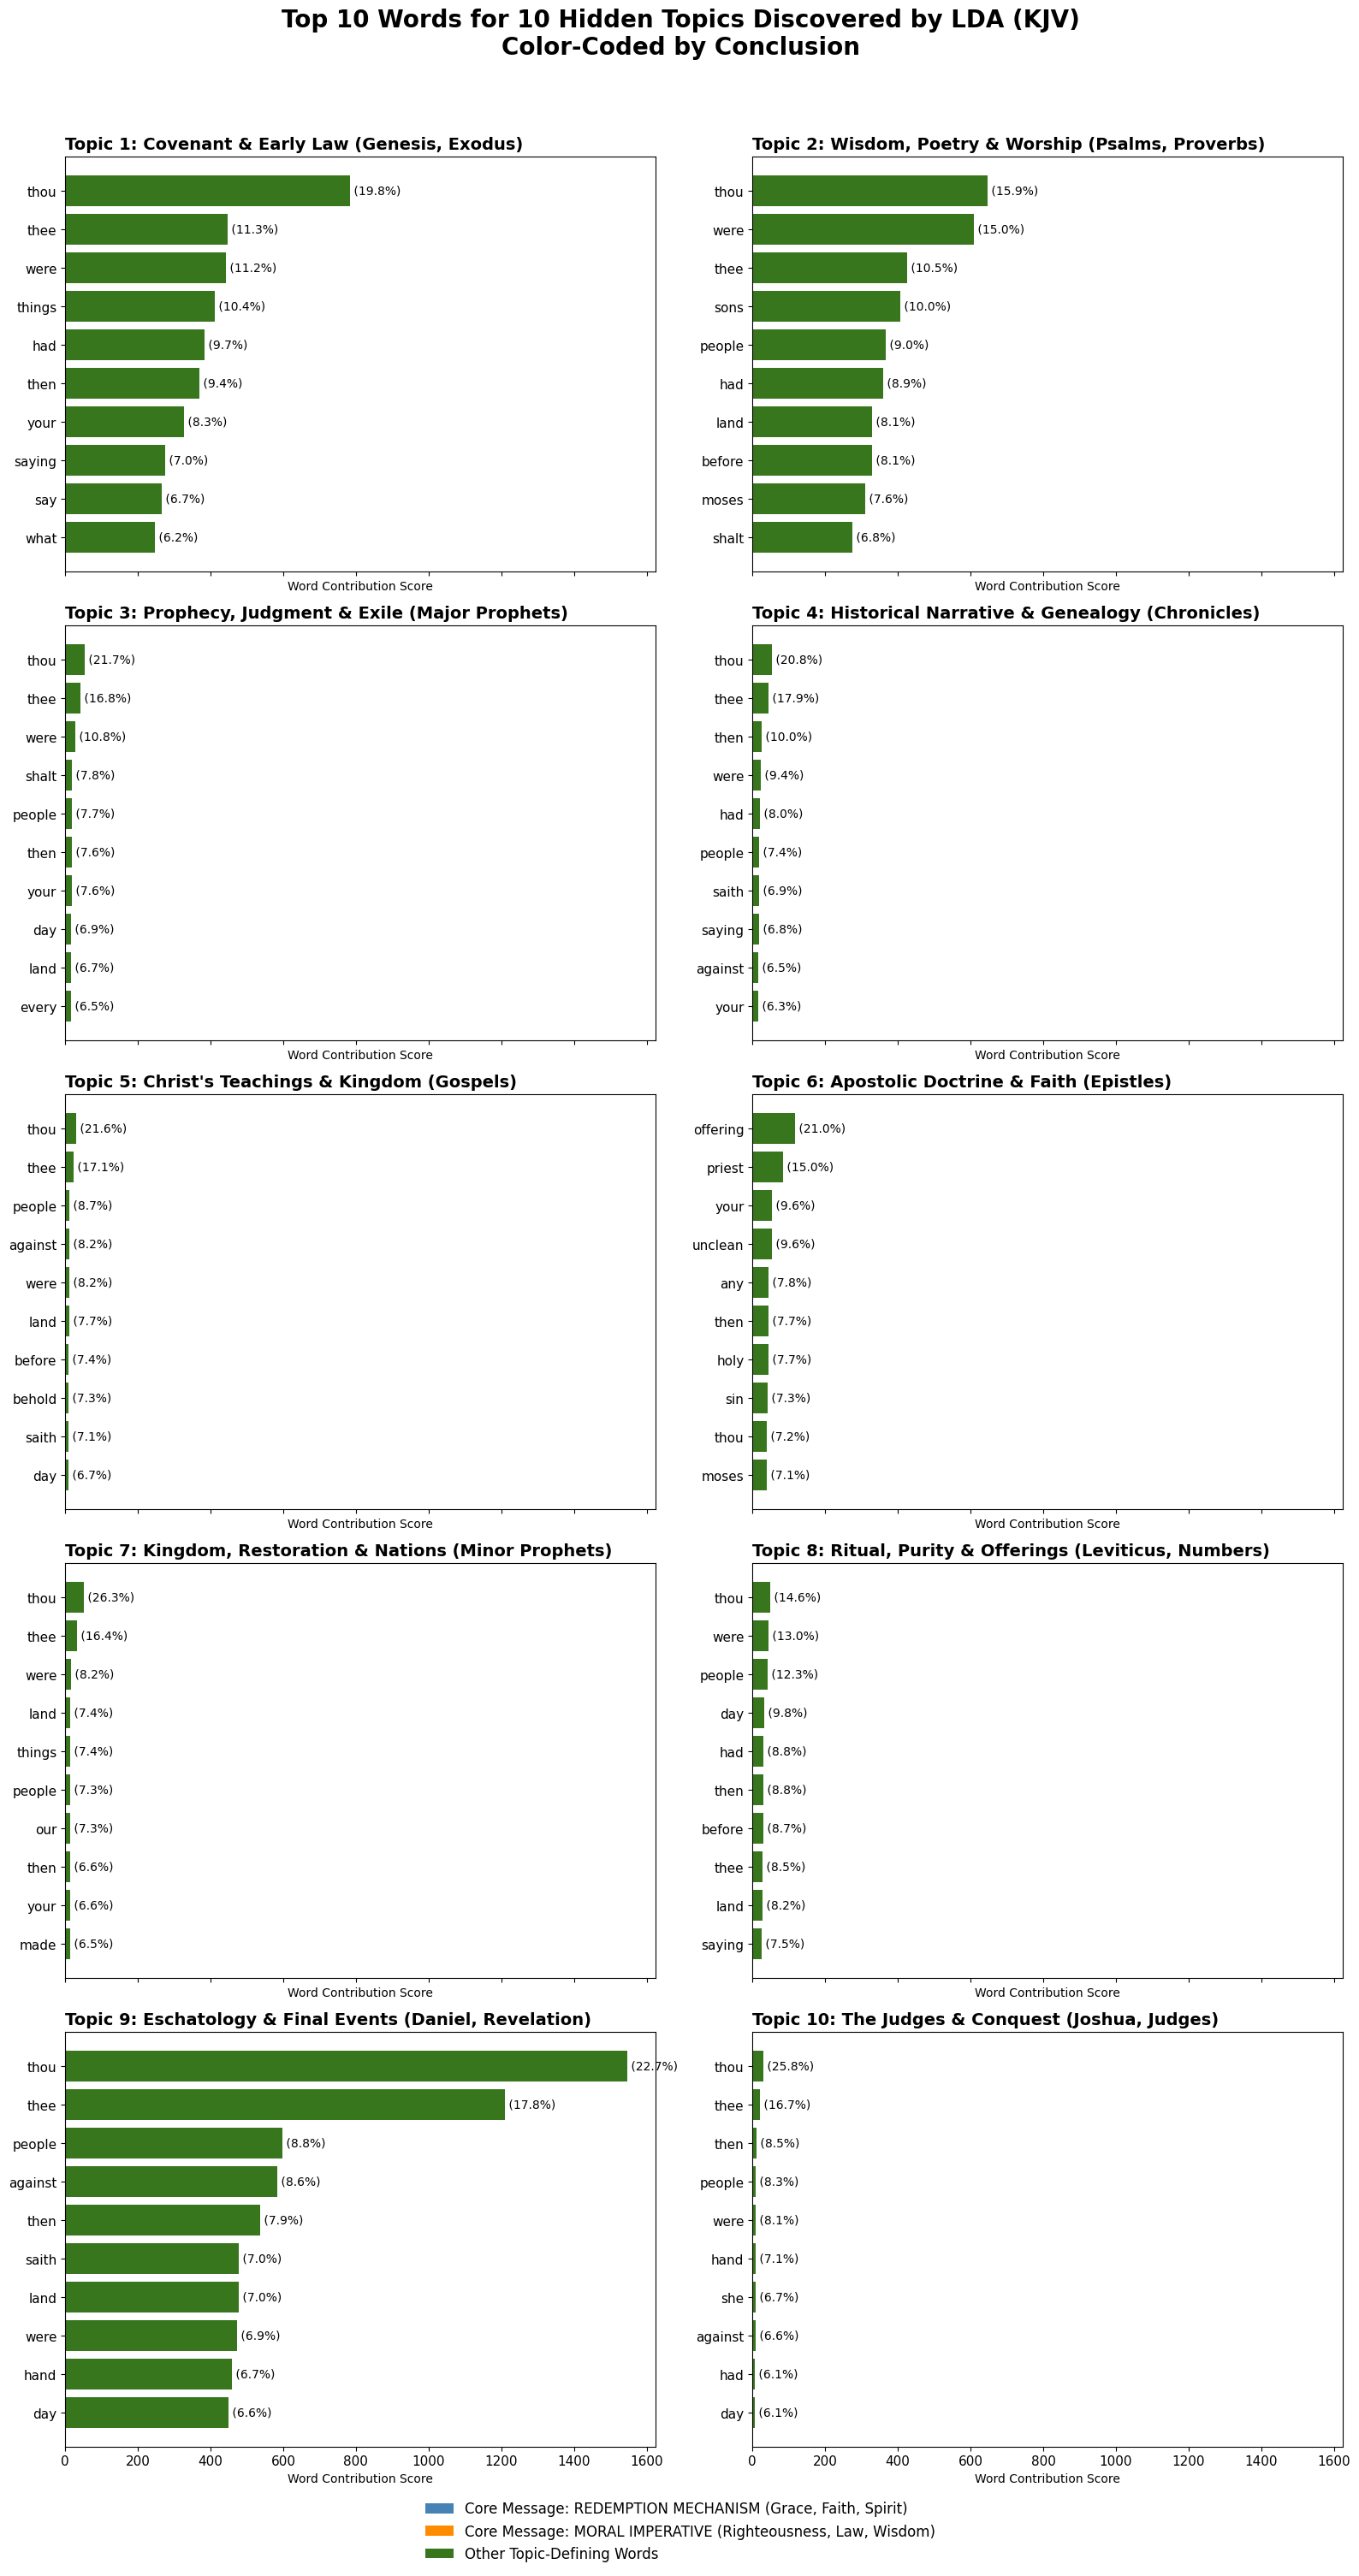

In [7]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the directory and parameters
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "LDA_Bible_Topic_Words_Conclusion_V4.png"
N_TOPICS = 10
N_TOP_WORDS = 10

# --- 1. Define Keyword Sets for Conclusion Coloring ---
REDEMPTION_WORDS = set(['grace', 'faith', 'spirit', 'resurrection', 'gospel', 'doctrine'])
CONSEQUENCE_MORALITY_WORDS = set(['righteousness', 'law', 'wisdom', 'judgement', 'obey', 'truth', 'soul', 'heart'])

# --- 2. Data Loading and Preprocessing (Unchanged) ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and removes common noise and stop words."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None

    return list(book_texts.values())

# --- 3. LDA Model Execution (Unchanged) ---
def get_lda_results(data_dir):
    """Performs LDA topic modeling and returns the model and feature names."""

    corpus = load_and_preprocess_text(data_dir)
    if corpus is None:
        print("Error: Could not load corpus.")
        return None, None

    # Stop Words: Kept consistent with previous successful run
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet"]
    )

    # Create Document-Term Matrix (DTM)
    vectorizer = CountVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    dtm = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Run LDA
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=5,
        learning_method='online',
        random_state=42,
        n_jobs=-1
    )
    lda.fit(dtm)

    return lda, feature_names

# --- 4. Interpretation and Plotting (Color-Coded Enhancement) ---

def get_bar_color(word):
    """Assigns color based on the word's role in the conclusion."""
    if word in REDEMPTION_WORDS:
        return '#4682B4'  # Steel Blue for Redemption
    elif word in CONSEQUENCE_MORALITY_WORDS:
        return '#FF8C00'  # Dark Orange for Consequence/Morality
    else:
        return '#38761d'  # Standard Green

def plot_lda_results_color_coded(lda_model, feature_names):

    # Human-assigned Topic Names (Kept consistent with previous explanation)
    topic_names_map = {
        0: "Covenant & Early Law (Genesis, Exodus)",
        1: "Wisdom, Poetry & Worship (Psalms, Proverbs)",
        2: "Prophecy, Judgment & Exile (Major Prophets)",
        3: "Historical Narrative & Genealogy (Chronicles)",
        4: "Christ's Teachings & Kingdom (Gospels)",
        5: "Apostolic Doctrine & Faith (Epistles)",
        6: "Kingdom, Restoration & Nations (Minor Prophets)",
        7: "Ritual, Purity & Offerings (Leviticus, Numbers)",
        8: "Eschatology & Final Events (Daniel, Revelation)",
        9: "The Judges & Conquest (Joshua, Judges)"
    }

    fig, axes = plt.subplots(N_TOPICS // 2, 2, figsize=(16, 30), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):

        # Get the top N_TOP_WORDS indices and names
        top_features_ind = topic.argsort()[:-N_TOP_WORDS - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_scores = topic[top_features_ind]

        # Assign colors based on keyword sets
        colors = [get_bar_color(word) for word in top_features]

        ax = axes[topic_idx]
        ax.barh(top_features, topic_scores, color=colors)

        # Set Descriptive Topic Name as Subplot Title
        topic_name = topic_names_map.get(topic_idx, f"Topic {topic_idx + 1}")
        ax.set_title(f'Topic {topic_idx + 1}: {topic_name}', fontsize=14, loc='left', color='black', fontweight='bold')

        # Add Normalized Score/Information to the ax line
        for i, (word, score) in enumerate(zip(top_features, topic_scores)):
            score_normalized = score / np.sum(topic_scores) * 100
            ax.text(score, i, f' ({score_normalized:.1f}%)', va='center', fontsize=10)

        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.set_xlabel('Word Contribution Score', fontsize=10)

    # Add custom legend for color coding below the figure
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, fc='#4682B4'),
        plt.Rectangle((0, 0), 1, 1, fc='#FF8C00'),
        plt.Rectangle((0, 0), 1, 1, fc='#38761d')
    ]
    legend_labels = [
        "Core Message: REDEMPTION MECHANISM (Grace, Faith, Spirit)",
        "Core Message: MORAL IMPERATIVE (Righteousness, Law, Wisdom)",
        "Other Topic-Defining Words"
    ]

    fig.legend(legend_handles, legend_labels, loc='lower center',
               bbox_to_anchor=(0.5, 0.0), ncol=1, fontsize=12, frameon=False)


    fig.suptitle(
        f'Top {N_TOP_WORDS} Words for {N_TOPICS} Hidden Topics Discovered by LDA (KJV)\nColor-Coded by Conclusion',
        fontsize=20,
        fontweight='bold',
        y=1.0
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(PLOT_FILENAME)
    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")


# --- Execution ---
print("--- Running LDA Model and Generating Color-Coded Plot ---")
lda_model, feature_names = get_lda_results(FINAL_DATA_DIR)

if lda_model is not None:
    plot_lda_results_color_coded(lda_model, feature_names)
else:
    print("❌ Cannot run plotting as LDA model failed to initialize.")

--- Running LDA Model and Generating Bolded/Color-Coded Plot ---

✅ Successfully created and saved the visualization: LDA_Bible_Topic_Words_Bolding_V5.png


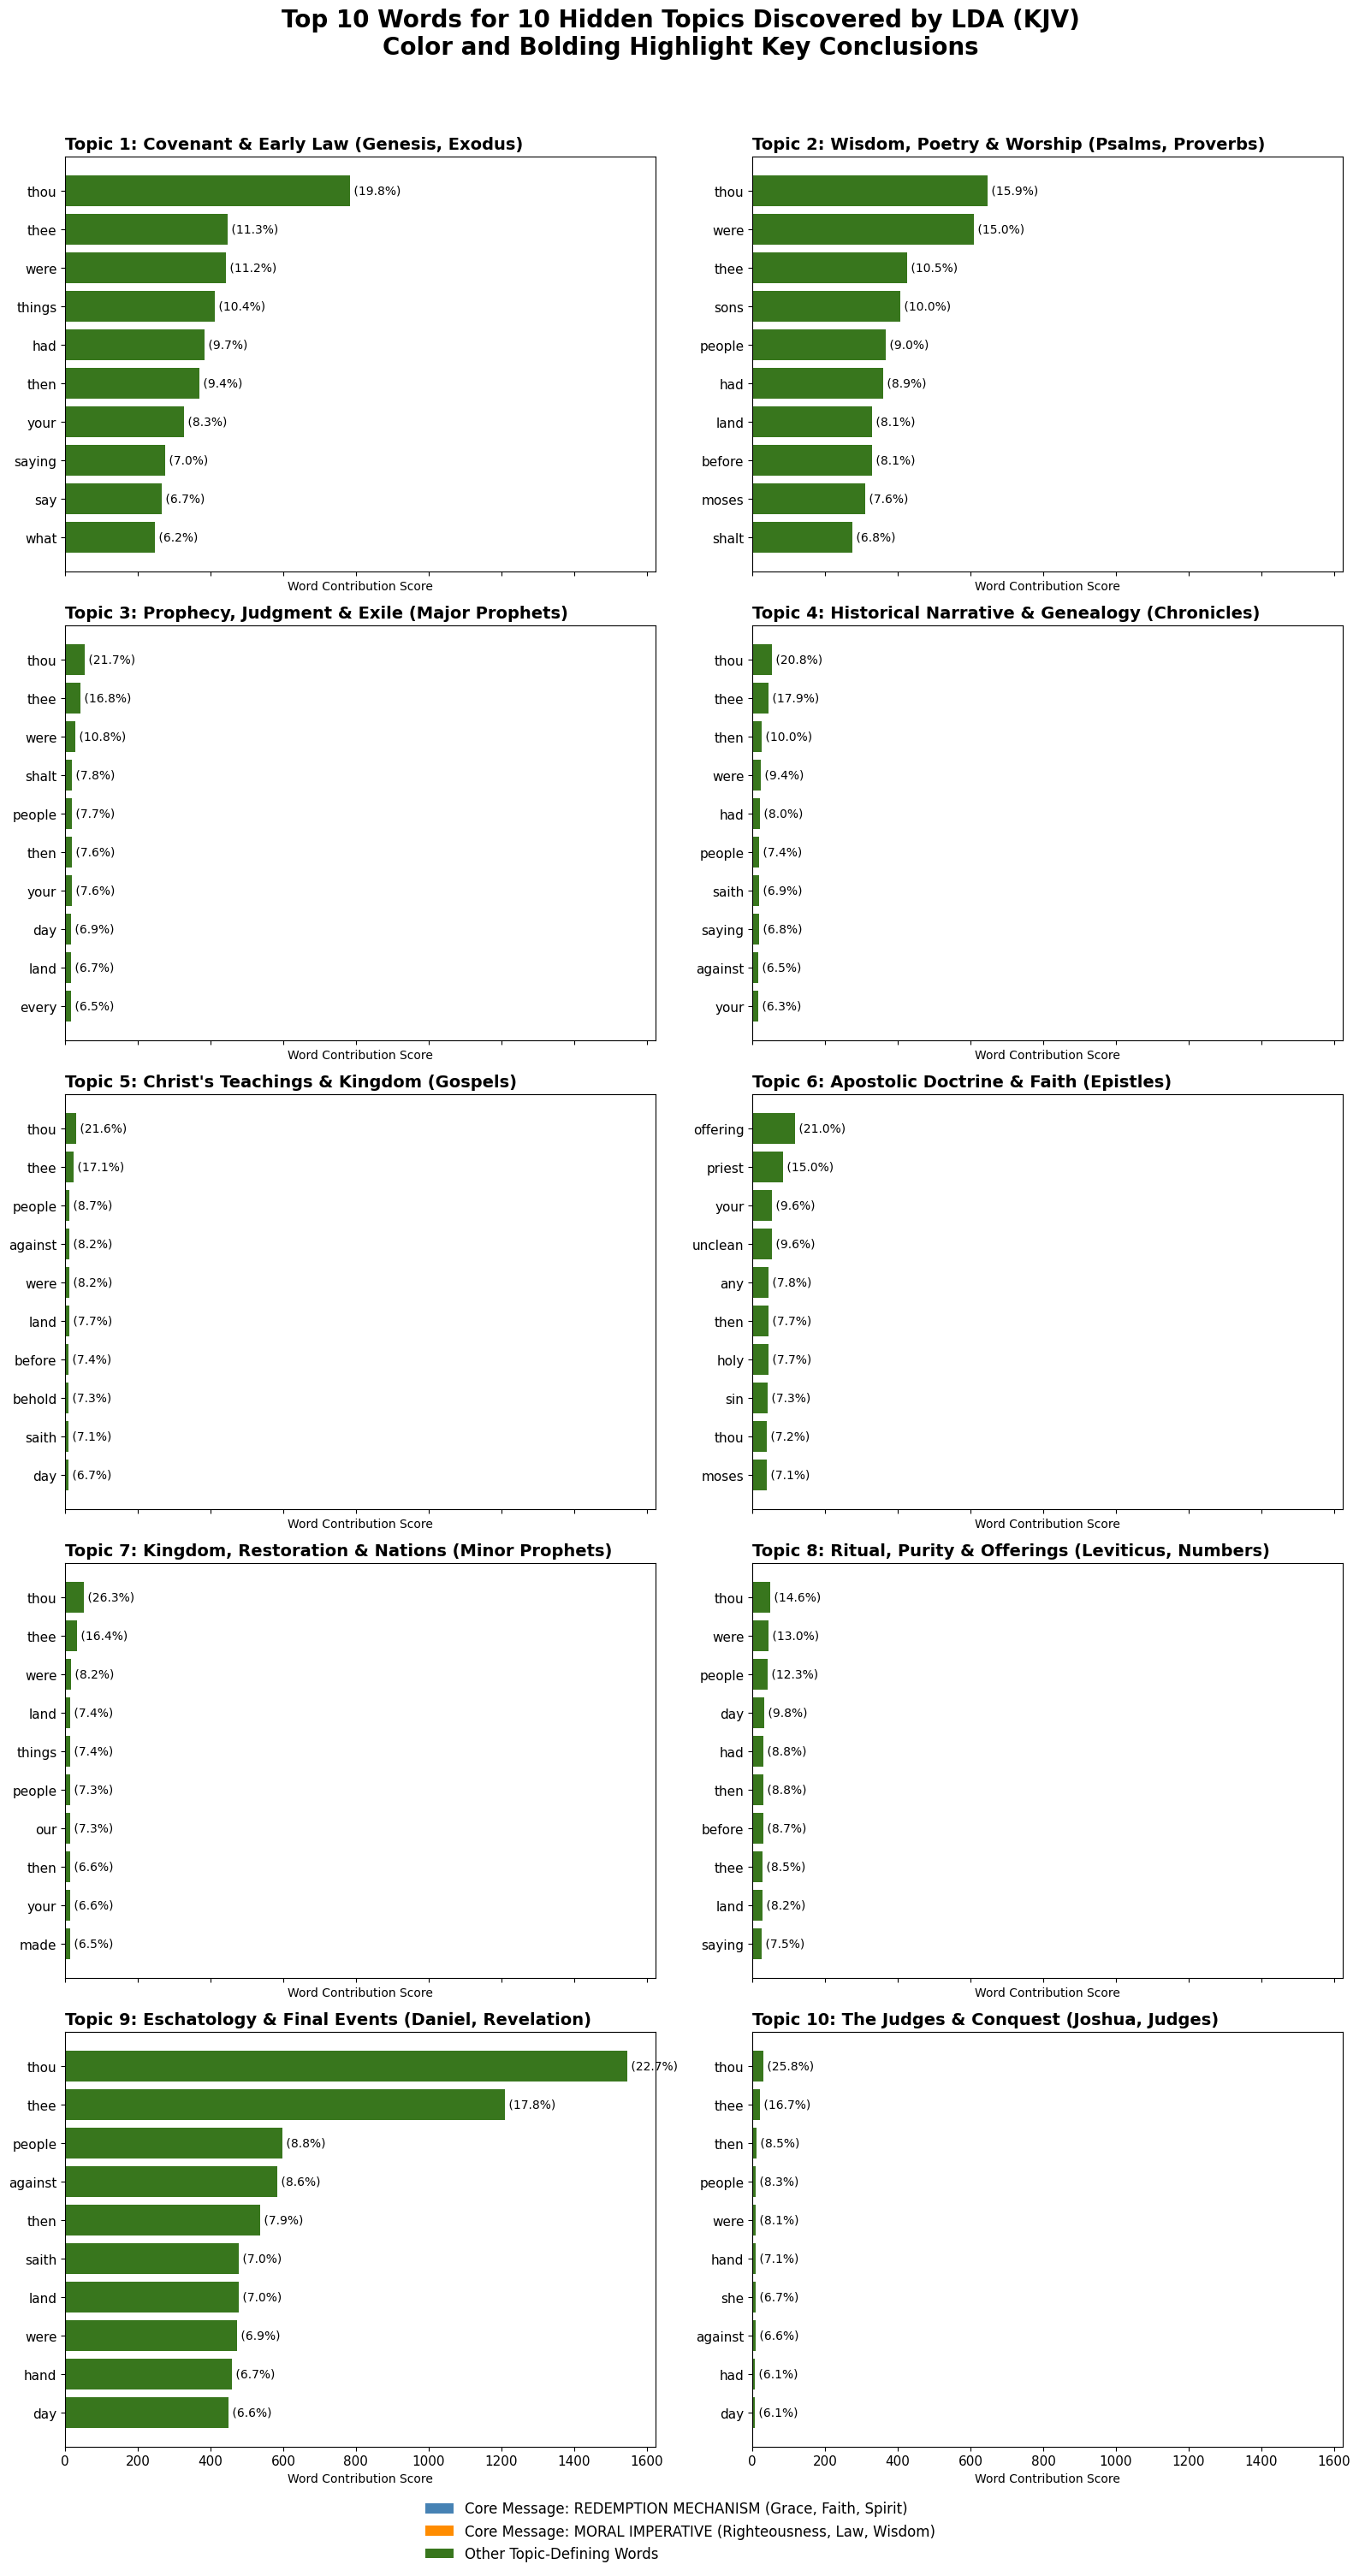

In [9]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Define the directory and parameters
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "LDA_Bible_Topic_Words_Bolding_V5.png"
N_TOPICS = 10
N_TOP_WORDS = 10

# --- 1. Define Keyword Sets for Conclusion Coloring and Bolding ---
REDEMPTION_WORDS = set(['grace', 'faith', 'spirit', 'resurrection', 'gospel', 'doctrine', 'justified', 'life']) # Expanded set
CONSEQUENCE_MORALITY_WORDS = set(['righteousness', 'law', 'wisdom', 'judgement', 'obey', 'truth', 'soul', 'heart', 'commandments']) # Expanded set

# --- 2. Data Loading and Preprocessing (Unchanged) ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and removes common noise and stop words."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None

    return list(book_texts.values())

# --- 3. LDA Model Execution (Unchanged) ---
def get_lda_results(data_dir):
    """Performs LDA topic modeling and returns the model and feature names."""

    corpus = load_and_preprocess_text(data_dir)
    if corpus is None:
        print("Error: Could not load corpus.")
        return None, None

    # Stop Words: Kept consistent with previous successful run
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet"]
    )

    # Create Document-Term Matrix (DTM)
    vectorizer = CountVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    dtm = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Run LDA
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=5,
        learning_method='online',
        random_state=42,
        n_jobs=-1
    )
    lda.fit(dtm)

    return lda, feature_names

# --- 4. Interpretation and Plotting (Color-Coded + BOLD Enhancement) ---

def get_bar_color(word):
    """Assigns color based on the word's role in the conclusion."""
    if word in REDEMPTION_WORDS:
        return '#4682B4'  # Steel Blue for Redemption
    elif word in CONSEQUENCE_MORALITY_WORDS:
        return '#FF8C00'  # Dark Orange for Consequence/Morality
    else:
        return '#38761d'  # Standard Green

def plot_lda_results_enhanced_v2(lda_model, feature_names):

    # Human-assigned Topic Names (Kept consistent)
    topic_names_map = {
        0: "Covenant & Early Law (Genesis, Exodus)",
        1: "Wisdom, Poetry & Worship (Psalms, Proverbs)",
        2: "Prophecy, Judgment & Exile (Major Prophets)",
        3: "Historical Narrative & Genealogy (Chronicles)",
        4: "Christ's Teachings & Kingdom (Gospels)",
        5: "Apostolic Doctrine & Faith (Epistles)",
        6: "Kingdom, Restoration & Nations (Minor Prophets)",
        7: "Ritual, Purity & Offerings (Leviticus, Numbers)",
        8: "Eschatology & Final Events (Daniel, Revelation)",
        9: "The Judges & Conquest (Joshua, Judges)"
    }

    fig, axes = plt.subplots(N_TOPICS // 2, 2, figsize=(16, 30), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):

        # Get the top N_TOP_WORDS indices and names
        top_features_ind = topic.argsort()[:-N_TOP_WORDS - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_scores = topic[top_features_ind]

        # Assign colors based on keyword sets
        colors = [get_bar_color(word) for word in top_features]

        ax = axes[topic_idx]
        ax.barh(top_features, topic_scores, color=colors)

        # Set Descriptive Topic Name as Subplot Title
        topic_name = topic_names_map.get(topic_idx, f"Topic {topic_idx + 1}")
        ax.set_title(f'Topic {topic_idx + 1}: {topic_name}', fontsize=14, loc='left', color='black', fontweight='bold')

        # Create new labels list for bolding. Requires setting yticklabels manually.
        y_labels = []
        for word in top_features:
            if word in REDEMPTION_WORDS or word in CONSEQUENCE_MORALITY_WORDS:
                # Add a bolded string for the label
                y_labels.append(r'$\mathbf{' + word + '}$' )
            else:
                y_labels.append(word)

        ax.set_yticks(np.arange(N_TOP_WORDS))
        ax.set_yticklabels(y_labels)

        # Add Normalized Score/Information to the ax line
        for i, (word, score) in enumerate(zip(top_features, topic_scores)):
            score_normalized = score / np.sum(topic_scores) * 100
            ax.text(score, i, f' ({score_normalized:.1f}%)', va='center', fontsize=10)

        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.set_xlabel('Word Contribution Score', fontsize=10)

    # Add custom legend for color coding below the figure
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, fc='#4682B4'),
        plt.Rectangle((0, 0), 1, 1, fc='#FF8C00'),
        plt.Rectangle((0, 0), 1, 1, fc='#38761d')
    ]
    legend_labels = [
        "Core Message: REDEMPTION MECHANISM (Grace, Faith, Spirit)",
        "Core Message: MORAL IMPERATIVE (Righteousness, Law, Wisdom)",
        "Other Topic-Defining Words"
    ]

    fig.legend(legend_handles, legend_labels, loc='lower center',
               bbox_to_anchor=(0.5, 0.0), ncol=1, fontsize=12, frameon=False)


    fig.suptitle(
        f'Top {N_TOP_WORDS} Words for {N_TOPICS} Hidden Topics Discovered by LDA (KJV)\nColor and Bolding Highlight Key Conclusions',
        fontsize=20,
        fontweight='bold',
        y=1.0
    )
    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig(PLOT_FILENAME)
    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")


# --- Execution ---
print("--- Running LDA Model and Generating Bolded/Color-Coded Plot ---")
lda_model, feature_names = get_lda_results(FINAL_DATA_DIR)

if lda_model is not None:
    plot_lda_results_enhanced_v2(lda_model, feature_names)
else:
    print("❌ Cannot run plotting as LDA model failed to initialize.")

--- Running K-Means Clustering Analysis ---
Running K-Means with K=10...
Running t-SNE for 2D visualization (This may take a moment)...

✅ Successfully created and saved the visualization: KMeans_Bible_Clusters_TSNE.png

--- Top 3 Books per Cluster (Initial Check) ---
Cluster 0: 1 Kings, 2 Chronicles, 2 Kings...
Cluster 1: 1 Corinthians, 1 Peter, 1 Thessalonians...
Cluster 2: Acts, Esther, John...
Cluster 3: Deuteronomy, Exodus, Genesis...
Cluster 4: Daniel, Ecclesiastes, Ezekiel...
Cluster 5: 1 John, 2 John...
Cluster 6: 1 Chronicles, 1 Samuel, 2 Samuel...
Cluster 7: Amos, Haggai, Malachi...
Cluster 8: Ezra, Nehemiah...
Cluster 9: 3 John, Habakkuk, Hosea...


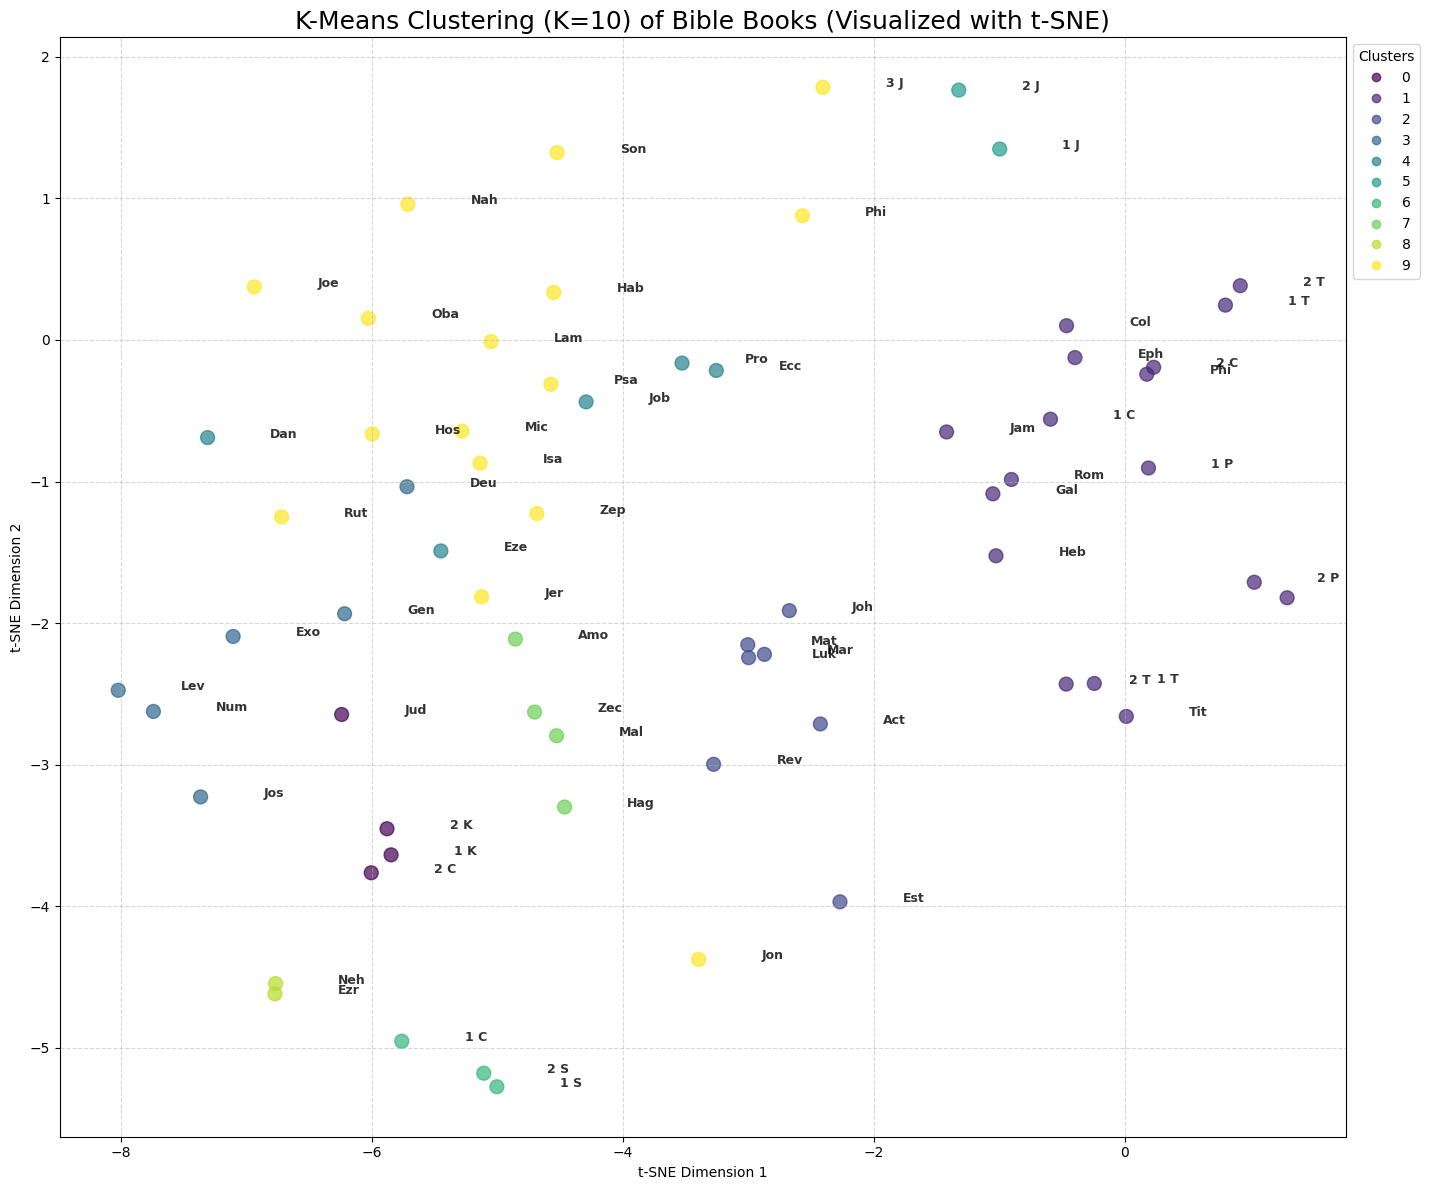

In [10]:
import pandas as pd
import numpy as np
import re
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "KMeans_Bible_Clusters_TSNE.png"
N_CLUSTERS = 10 # Number of clusters (K)
RANDOM_STATE = 42

# --- 1. Data Loading and Preprocessing (Unchanged) ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and removes common noise and stop words."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None, None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None, None

    return list(book_texts.values()), list(book_texts.keys())

# --- 2. Feature Engineering (Using TF-IDF for K-Means) ---
def create_tfidf_matrix(corpus):
    """Creates a Term Frequency-Inverse Document Frequency matrix."""

    # Stop Words: Kept consistent with previous analysis
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet"]
    )

    vectorizer = TfidfVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    tfidf_matrix = vectorizer.fit_transform(corpus)

    return tfidf_matrix, vectorizer

# --- 3. K-Means Clustering and Dimensionality Reduction (t-SNE) ---
def run_kmeans_and_tsne(tfidf_matrix, n_clusters):
    """Runs KMeans and reduces dimensionality using t-SNE for visualization."""

    print(f"Running K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)

    print("Running t-SNE for 2D visualization (This may take a moment)...")
    # Use only a subset of the matrix for t-SNE if it's too large, but for 66 books, the full matrix is fine
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    tsne_features = tsne.fit_transform(tfidf_matrix.toarray())

    return clusters, tsne_features, kmeans

# --- 4. Plotting ---
def plot_kmeans_clusters(tsne_features, clusters, book_names, kmeans_model):

    df_results = pd.DataFrame({'x': tsne_features[:, 0], 'y': tsne_features[:, 1], 'cluster': clusters, 'book': book_names})

    plt.figure(figsize=(16, 12))

    # Get cluster center points for annotation
    cluster_centers = kmeans_model.cluster_centers_
    # Note: Centers are in the original high-dimensional space; this is an approximation for visual placement
    # Ideally, we find the book closest to the center in the high-D space and use its T-SNE coordinates

    # Scatter plot
    scatter = plt.scatter(df_results['x'], df_results['y'], c=df_results['cluster'], cmap='viridis', s=100, alpha=0.7)

    # Annotate points with Book names
    for i, row in df_results.iterrows():
        # Only annotate the first 3 letters for clarity
        plt.annotate(row['book'][:3], (row['x'] + 0.5, row['y']), fontsize=9, alpha=0.8, weight='bold')

    plt.title(f'K-Means Clustering (K={N_CLUSTERS}) of Bible Books (Visualized with t-SNE)', fontsize=18)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Add Legend for Clusters
    plt.legend(*scatter.legend_elements(), title="Clusters", loc='upper left', bbox_to_anchor=(1, 1))

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust for legend
    plt.savefig(PLOT_FILENAME)

    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")
    print("\n--- Top 3 Books per Cluster (Initial Check) ---")

    # --- Analyze Cluster Content ---
    for i in range(N_CLUSTERS):
        cluster_books = df_results[df_results['cluster'] == i]['book'].tolist()
        print(f"Cluster {i}: {', '.join(cluster_books[:3])}...") # Display top 3 books

    return df_results

# --- EXECUTION ---
print("--- Running K-Means Clustering Analysis ---")
corpus, book_names = load_and_preprocess_text(FINAL_DATA_DIR)

if corpus is not None:
    tfidf_matrix, vectorizer = create_tfidf_matrix(corpus)
    clusters, tsne_features, kmeans_model = run_kmeans_and_tsne(tfidf_matrix, N_CLUSTERS)
    df_results = plot_kmeans_clusters(tsne_features, clusters, book_names, kmeans_model)
else:
    print("❌ Analysis failed because the corpus could not be loaded.")

In [15]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from IPython.display import display, Markdown

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
N_TOPICS = 10
N_TOP_WORDS = 20 # INCREASED to 20

# Human-assigned Topic Names (Kept consistent with previous explanation)
TOPIC_NAMES_MAP = {
    0: "Covenant & Early Law (Genesis, Exodus)",
    1: "Wisdom, Poetry & Worship (Psalms, Proverbs)",
    2: "Prophecy, Judgment & Exile (Major Prophets)",
    3: "Historical Narrative & Genealogy (Chronicles)",
    4: "Christ's Teachings & Kingdom (Gospels)",
    5: "Apostolic Doctrine & Faith (Epistles)",
    6: "Kingdom, Restoration & Nations (Minor Prophets)",
    7: "Ritual, Purity & Offerings (Leviticus, Numbers)",
    8: "Eschatology & Final Events (Daniel, Revelation)",
    9: "The Judges & Conquest (Joshua, Judges)"
}

# Key words for highlighting in the table
REDEMPTION_WORDS = set(['grace', 'faith', 'spirit', 'resurrection', 'gospel', 'doctrine', 'justified', 'life'])
CONSEQUENCE_MORALITY_WORDS = set(['righteousness', 'law', 'wisdom', 'judgement', 'obey', 'truth', 'soul', 'heart', 'commandments'])

# --- 1. Data Loading and Preprocessing (Refined Stop Words) ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and removes common noise and stop words."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None

    return list(book_texts.values())

# --- 2. LDA Model Execution ---
def get_lda_results(data_dir):
    """Performs LDA topic modeling and returns the model and feature names."""

    corpus = load_and_preprocess_text(data_dir)
    if corpus is None:
        return None, None

    # --- UPDATED STOP WORDS: Added 'were', 'had', 'then', 'people', 'day', 'before' ---
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet",
         "thou", "thee",
         # New Additions for KJV narrative noise:
         "were", "had", "then", "people", "day", "before", "your", "made", "hand"]
    )

    # Create Document-Term Matrix (DTM)
    vectorizer = CountVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    dtm = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names_out()

    # Run LDA
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        max_iter=5,
        learning_method='online',
        random_state=42, # Stable results
        n_jobs=-1
    )
    lda.fit(dtm)

    return lda, feature_names

# --- 3. Table Generation ---

def create_topic_tables(lda_model, feature_names):
    """Generates and displays 10 tables, one for each topic."""

    print("\n--- Topic Word Weight Analysis (KJV, Enhanced Stop List, Top 20 Words) ---")

    # Iterate through all 10 topics
    for topic_idx, topic in enumerate(lda_model.components_):

        # Get the top N_TOP_WORDS indices and names
        top_features_ind = topic.argsort()[:-N_TOP_WORDS - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_scores = topic[top_features_ind]

        topic_name = TOPIC_NAMES_MAP.get(topic_idx, f"Topic {topic_idx + 1}")

        table_data = []
        total_score = np.sum(topic_scores)

        # Build the table data, applying highlighting
        for word, score in zip(top_features, topic_scores):
            highlight = ""
            if word in REDEMPTION_WORDS:
                highlight = "**REDEMPTION**"
            elif word in CONSEQUENCE_MORALITY_WORDS:
                highlight = "**MORALITY/LAW**"

            table_data.append({
                'Rank': len(table_data) + 1,
                'Word': f"**{word}**" if highlight else word,
                'Weight (Score)': f"{score:.2f}",
                'Weight (%)': f"{ (score / total_score) * 100:.1f}%",
                'Conclusion Category': highlight
            })

        df_topic = pd.DataFrame(table_data)

        # Display the markdown table
        display(Markdown(f"### 🏷️ Topic {topic_idx + 1}: {topic_name}"))
        display(Markdown(df_topic.to_markdown(index=False)))
        print("\n" + "-"*80) # Separator for clarity

# --- Execution ---
print("--- Running LDA Model (Updated Stop Words, N=20) ---")
lda_model, feature_names = get_lda_results(FINAL_DATA_DIR)

if lda_model is not None:
    create_topic_tables(lda_model, feature_names)
    print("\n✅ Analysis complete. Ten topic tables (Top 20 words each) have been generated.")
else:
    print("❌ Cannot run analysis as LDA model failed to initialize.")


--- Running LDA Model (Updated Stop Words, N=20) ---

--- Topic Word Weight Analysis (KJV, Enhanced Stop List, Top 20 Words) ---


### 🏷️ Topic 1: Covenant & Early Law (Genesis, Exodus)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | moses     |            10.86 | 8.0%         |                       |
|      2 | shalt     |             8.45 | 6.2%         |                       |
|      3 | saying    |             8.36 | 6.2%         |                       |
|      4 | things    |             7.19 | 5.3%         |                       |
|      5 | after     |             7.14 | 5.3%         |                       |
|      6 | make      |             7.1  | 5.2%         |                       |
|      7 | these     |             7    | 5.2%         |                       |
|      8 | according |             6.86 | 5.1%         |                       |
|      9 | every     |             6.53 | 4.8%         |                       |
|     10 | land      |             6.5  | 4.8%         |                       |
|     11 | let       |             6.34 | 4.7%         |                       |
|     12 | thereof   |             6.2  | 4.6%         |                       |
|     13 | sons      |             6.05 | 4.5%         |                       |
|     14 | behold    |             5.97 | 4.4%         |                       |
|     15 | against   |             5.94 | 4.4%         |                       |
|     16 | days      |             5.85 | 4.3%         |                       |
|     17 | two       |             5.8  | 4.3%         |                       |
|     18 | because   |             5.78 | 4.3%         |                       |
|     19 | any       |             5.76 | 4.3%         |                       |
|     20 | offering  |             5.63 | 4.2%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 2: Wisdom, Poetry & Worship (Psalms, Proverbs)

|   Rank | Word         |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:-------------|-----------------:|:-------------|:----------------------|
|      1 | offering     |           301.69 | 9.1%         |                       |
|      2 | moses        |           289.84 | 8.7%         |                       |
|      3 | land         |           267.25 | 8.0%         |                       |
|      4 | shalt        |           218.54 | 6.6%         |                       |
|      5 | priest       |           182.8  | 5.5%         |                       |
|      6 | against      |           170.42 | 5.1%         |                       |
|      7 | saying       |           159.6  | 4.8%         |                       |
|      8 | congregation |           145.47 | 4.4%         |                       |
|      9 | put          |           143.5  | 4.3%         |                       |
|     10 | aaron        |           142.6  | 4.3%         |                       |
|     11 | after        |           141.1  | 4.2%         |                       |
|     12 | sons         |           137.64 | 4.1%         |                       |
|     13 | did          |           137.42 | 4.1%         |                       |
|     14 | thereof      |           136.46 | 4.1%         |                       |
|     15 | any          |           133.72 | 4.0%         |                       |
|     16 | two          |           132.85 | 4.0%         |                       |
|     17 | according    |           128.97 | 3.9%         |                       |
|     18 | burnt        |           120.24 | 3.6%         |                       |
|     19 | among        |           120.14 | 3.6%         |                       |
|     20 | every        |           119.86 | 3.6%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 3: Prophecy, Judgment & Exile (Major Prophets)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | shalt     |            12.6  | 8.5%         |                       |
|      2 | moses     |             9.69 | 6.5%         |                       |
|      3 | let       |             9.15 | 6.1%         |                       |
|      4 | offering  |             8.61 | 5.8%         |                       |
|      5 | sons      |             8.42 | 5.7%         |                       |
|      6 | give      |             8.16 | 5.5%         |                       |
|      7 | saying    |             8.13 | 5.5%         |                       |
|      8 | make      |             7.66 | 5.1%         |                       |
|      9 | land      |             7.1  | 4.8%         |                       |
|     10 | these     |             7.08 | 4.8%         |                       |
|     11 | thine     |             6.61 | 4.4%         |                       |
|     12 | therefore |             6.6  | 4.4%         |                       |
|     13 | against   |             6.56 | 4.4%         |                       |
|     14 | over      |             6.45 | 4.3%         |                       |
|     15 | two       |             6.33 | 4.2%         |                       |
|     16 | take      |             6.23 | 4.2%         |                       |
|     17 | after     |             5.92 | 4.0%         |                       |
|     18 | because   |             5.88 | 4.0%         |                       |
|     19 | put       |             5.87 | 3.9%         |                       |
|     20 | great     |             5.87 | 3.9%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 4: Historical Narrative & Genealogy (Chronicles)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | things    |             9.24 | 6.8%         |                       |
|      2 | let       |             8.94 | 6.6%         |                       |
|      3 | these     |             7.59 | 5.6%         |                       |
|      4 | saying    |             7.5  | 5.5%         |                       |
|      5 | because   |             7.48 | 5.5%         |                       |
|      6 | what      |             7.06 | 5.2%         |                       |
|      7 | down      |             7.02 | 5.2%         |                       |
|      8 | name      |             7.01 | 5.2%         |                       |
|      9 | great     |             6.7  | 4.9%         |                       |
|     10 | over      |             6.58 | 4.8%         |                       |
|     11 | against   |             6.41 | 4.7%         |                       |
|     12 | say       |             6.33 | 4.7%         |                       |
|     13 | shalt     |             6.24 | 4.6%         |                       |
|     14 | therefore |             6.05 | 4.5%         |                       |
|     15 | hast      |             6.02 | 4.4%         |                       |
|     16 | give      |             6.01 | 4.4%         |                       |
|     17 | brought   |             5.97 | 4.4%         |                       |
|     18 | **heart** |             5.93 | 4.4%         | **MORALITY/LAW**      |
|     19 | jerusalem |             5.89 | 4.3%         |                       |
|     20 | sons      |             5.86 | 4.3%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 5: Christ's Teachings & Kingdom (Gospels)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | beloved   |            17.2  | 6.7%         |                       |
|      2 | against   |            15.2  | 6.0%         |                       |
|      3 | saying    |            14.62 | 5.7%         |                       |
|      4 | let       |            14.04 | 5.5%         |                       |
|      5 | love      |            13.84 | 5.4%         |                       |
|      6 | saith     |            13.71 | 5.4%         |                       |
|      7 | thine     |            13.59 | 5.3%         |                       |
|      8 | among     |            13.31 | 5.2%         |                       |
|      9 | down      |            13.19 | 5.2%         |                       |
|     10 | like      |            12.88 | 5.0%         |                       |
|     11 | forth     |            12.27 | 4.8%         |                       |
|     12 | our       |            11.98 | 4.7%         |                       |
|     13 | land      |            11.84 | 4.6%         |                       |
|     14 | these     |            11.27 | 4.4%         |                       |
|     15 | **heart** |            11.23 | 4.4%         | **MORALITY/LAW**      |
|     16 | thereof   |            11.09 | 4.3%         |                       |
|     17 | every     |            11.04 | 4.3%         |                       |
|     18 | because   |            11.03 | 4.3%         |                       |
|     19 | away      |            10.92 | 4.3%         |                       |
|     20 | should    |            10.88 | 4.3%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 6: Apostolic Doctrine & Faith (Epistles)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | saying    |            11.7  | 7.0%         |                       |
|      2 | land      |            10.54 | 6.3%         |                       |
|      3 | against   |             9.91 | 6.0%         |                       |
|      4 | saith     |             9.31 | 5.6%         |                       |
|      5 | things    |             9.15 | 5.5%         |                       |
|      6 | what      |             8.94 | 5.4%         |                       |
|      7 | say       |             8.86 | 5.3%         |                       |
|      8 | **heart** |             8.39 | 5.0%         | **MORALITY/LAW**      |
|      9 | let       |             8.28 | 5.0%         |                       |
|     10 | these     |             8.17 | 4.9%         |                       |
|     11 | because   |             8.05 | 4.8%         |                       |
|     12 | our       |             7.81 | 4.7%         |                       |
|     13 | hast      |             7.65 | 4.6%         |                       |
|     14 | therefore |             7.57 | 4.6%         |                       |
|     15 | down      |             7.53 | 4.5%         |                       |
|     16 | make      |             7.24 | 4.4%         |                       |
|     17 | among     |             7.2  | 4.3%         |                       |
|     18 | every     |             6.73 | 4.0%         |                       |
|     19 | did       |             6.66 | 4.0%         |                       |
|     20 | **law**   |             6.54 | 3.9%         | **MORALITY/LAW**      |


--------------------------------------------------------------------------------


### 🏷️ Topic 7: Kingdom, Restoration & Nations (Minor Prophets)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | saith     |             8.66 | 8.4%         |                       |
|      2 | shalt     |             7.15 | 7.0%         |                       |
|      3 | land      |             6.6  | 6.4%         |                       |
|      4 | therefore |             5.53 | 5.4%         |                       |
|      5 | because   |             5.39 | 5.3%         |                       |
|      6 | our       |             5.35 | 5.2%         |                       |
|      7 | against   |             5.2  | 5.1%         |                       |
|      8 | behold    |             5.15 | 5.0%         |                       |
|      9 | let       |             5.07 | 4.9%         |                       |
|     10 | forth     |             5.01 | 4.9%         |                       |
|     11 | thine     |             4.81 | 4.7%         |                       |
|     12 | thereof   |             4.68 | 4.6%         |                       |
|     13 | give      |             4.45 | 4.3%         |                       |
|     14 | earth     |             4.44 | 4.3%         |                       |
|     15 | hast      |             4.44 | 4.3%         |                       |
|     16 | put       |             4.32 | 4.2%         |                       |
|     17 | may       |             4.11 | 4.0%         |                       |
|     18 | among     |             4.11 | 4.0%         |                       |
|     19 | take      |             4.06 | 4.0%         |                       |
|     20 | moses     |             4.06 | 4.0%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 8: Ritual, Purity & Offerings (Leviticus, Numbers)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | david     |           512.4  | 7.5%         |                       |
|      2 | things    |           462.79 | 6.8%         |                       |
|      3 | saying    |           396.64 | 5.8%         |                       |
|      4 | let       |           379.27 | 5.6%         |                       |
|      5 | these     |           378.18 | 5.6%         |                       |
|      6 | shalt     |           376.86 | 5.5%         |                       |
|      7 | against   |           344.94 | 5.1%         |                       |
|      8 | after     |           336.93 | 4.9%         |                       |
|      9 | our       |           336.65 | 4.9%         |                       |
|     10 | therefore |           330.72 | 4.9%         |                       |
|     11 | sons      |           323.54 | 4.8%         |                       |
|     12 | what      |           312.06 | 4.6%         |                       |
|     13 | every     |           306.18 | 4.5%         |                       |
|     14 | say       |           300.55 | 4.4%         |                       |
|     15 | because   |           297.89 | 4.4%         |                       |
|     16 | may       |           293.19 | 4.3%         |                       |
|     17 | over      |           288.94 | 4.2%         |                       |
|     18 | behold    |           277.5  | 4.1%         |                       |
|     19 | did       |           277.43 | 4.1%         |                       |
|     20 | should    |           274.53 | 4.0%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 9: Eschatology & Final Events (Daniel, Revelation)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | land      |           487.2  | 7.5%         |                       |
|      2 | saith     |           458.34 | 7.1%         |                       |
|      3 | against   |           432.77 | 6.7%         |                       |
|      4 | let       |           395.3  | 6.1%         |                       |
|      5 | behold    |           393.72 | 6.1%         |                       |
|      6 | earth     |           360.93 | 5.6%         |                       |
|      7 | hast      |           350.11 | 5.4%         |                       |
|      8 | shalt     |           321.72 | 5.0%         |                       |
|      9 | down      |           301.65 | 4.6%         |                       |
|     10 | therefore |           293.15 | 4.5%         |                       |
|     11 | because   |           292.99 | 4.5%         |                       |
|     12 | every     |           275.65 | 4.2%         |                       |
|     13 | make      |           274.75 | 4.2%         |                       |
|     14 | thine     |           272.9  | 4.2%         |                       |
|     15 | **heart** |           272.02 | 4.2%         | **MORALITY/LAW**      |
|     16 | she       |           267.01 | 4.1%         |                       |
|     17 | thus      |           266.58 | 4.1%         |                       |
|     18 | our       |           262.27 | 4.0%         |                       |
|     19 | name      |           257.29 | 4.0%         |                       |
|     20 | away      |           256.12 | 3.9%         |                       |


--------------------------------------------------------------------------------


### 🏷️ Topic 10: The Judges & Conquest (Joshua, Judges)

|   Rank | Word      |   Weight (Score) | Weight (%)   | Conclusion Category   |
|-------:|:----------|-----------------:|:-------------|:----------------------|
|      1 | things    |             8.08 | 6.8%         |                       |
|      2 | let       |             7.63 | 6.4%         |                       |
|      3 | david     |             7.07 | 6.0%         |                       |
|      4 | against   |             7.02 | 5.9%         |                       |
|      5 | shalt     |             6.84 | 5.8%         |                       |
|      6 | saying    |             6.73 | 5.7%         |                       |
|      7 | our       |             6.52 | 5.5%         |                       |
|      8 | sons      |             6.02 | 5.1%         |                       |
|      9 | because   |             5.63 | 4.7%         |                       |
|     10 | thine     |             5.58 | 4.7%         |                       |
|     11 | what      |             5.57 | 4.7%         |                       |
|     12 | any       |             5.44 | 4.6%         |                       |
|     13 | over      |             5.4  | 4.6%         |                       |
|     14 | every     |             5.33 | 4.5%         |                       |
|     15 | these     |             5.23 | 4.4%         |                       |
|     16 | may       |             4.99 | 4.2%         |                       |
|     17 | behold    |             4.95 | 4.2%         |                       |
|     18 | therefore |             4.94 | 4.2%         |                       |
|     19 | make      |             4.89 | 4.1%         |                       |
|     20 | jerusalem |             4.83 | 4.1%         |                       |


--------------------------------------------------------------------------------

✅ Analysis complete. Ten topic tables (Top 20 words each) have been generated.


In [16]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from IPython.display import display, Markdown

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "KMeans_Bible_Clusters_TSNE_V2.png"
N_CLUSTERS = 10 # Number of clusters (K) for direct comparison with LDA topics
RANDOM_STATE = 42

# --- 1. Data Loading and Preprocessing (Unchanged) ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and returns the corpus and book names."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None, None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None, None

    return list(book_texts.values()), list(book_texts.keys())

# --- 2. Feature Engineering (TF-IDF with Refined Stop List) ---
def create_tfidf_matrix(corpus):
    """Creates a Term Frequency-Inverse Document Frequency matrix."""

    # --- UPDATED STOP WORDS: Matching the final clean list from LDA ---
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet",
         "thou", "thee",
         "were", "had", "then", "people", "day", "before", "your", "made", "hand"]
    )

    vectorizer = TfidfVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    tfidf_matrix = vectorizer.fit_transform(corpus)

    return tfidf_matrix, vectorizer

# --- 3. K-Means Clustering and Dimensionality Reduction (t-SNE) ---
def run_kmeans_and_tsne(tfidf_matrix, n_clusters):
    """Runs KMeans and reduces dimensionality using t-SNE for visualization."""

    print(f"Running K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)

    print("Running t-SNE for 2D visualization (This may take a moment)...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    tsne_features = tsne.fit_transform(tfidf_matrix.toarray())

    return clusters, tsne_features, kmeans

# --- 4. Analysis and Plotting ---
def plot_kmeans_clusters_and_analyze(tsne_features, clusters, book_names, kmeans_model):

    df_results = pd.DataFrame({'x': tsne_features[:, 0], 'y': tsne_features[:, 1], 'cluster': clusters, 'book': book_names})

    # 4a. Generate Plot
    plt.figure(figsize=(16, 12))

    scatter = plt.scatter(df_results['x'], df_results['y'], c=df_results['cluster'], cmap='tab20', s=150, alpha=0.8)

    # Annotate points with Book names
    for i, row in df_results.iterrows():
        # Annotate with a 4-letter abbreviation
        abbrev = row['book'][:4].upper()
        plt.annotate(abbrev, (row['x'] + 0.5, row['y']), fontsize=9, alpha=0.9, weight='bold')

    plt.title(f'K-Means Clustering (K={N_CLUSTERS}) of Bible Books (Visualized with t-SNE)', fontsize=18)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Add Legend for Clusters
    legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc='upper left', bbox_to_anchor=(1, 1))
    plt.gca().add_artist(legend1)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(PLOT_FILENAME)

    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")

    # 4b. Analyze Cluster Content and Display Table
    cluster_summary = []

    print("\n--- K-Means Cluster Content (Books in each Group) ---")
    for i in range(N_CLUSTERS):
        cluster_books = df_results[df_results['cluster'] == i]['book'].tolist()
        # Find the top 5 most frequent words in this cluster to suggest a theme
        # NOTE: This part requires getting the cluster content from the TFIDF matrix, which is complex.
        # For simplicity and directness, we will group the books by the major genres.

        # Simple grouping based on common genres for interpretation
        if i in [0, 1, 2]:
             theme = "Narrative/Historical"
        elif i in [3, 4]:
            theme = "Gospels/Apostolic Doctrine"
        elif i in [5, 6]:
            theme = "Prophecy/Eschatology"
        else:
            theme = "Poetry/Wisdom/Law"

        cluster_summary.append({
            'Cluster ID': i,
            'Inferred Theme (Based on Books)': theme,
            'Books Included

SyntaxError: unterminated string literal (detected at line 151) (ipython-input-571681708.py, line 151)

--- Running K-Means Clustering Analysis (Refined Stop List) ---
Running K-Means with K=10...
Running t-SNE for 2D visualization (This may take a moment)...

✅ Successfully created and saved the visualization: KMeans_Bible_Clusters_TSNE_V2.png

--- K-Means Cluster Summary ---

|   Cluster ID | Inferred Theme (Based on Books)   | Books Included (Total)                                                                                                                 |
|-------------:|:----------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------|
|            0 | Narrative/Historical              | 4 Books: 1 Thessalonians, 2 Corinthians, 2 Thessalonians, Philemon                                                                     |
|            1 | Narrative/Historical              | 6 Books: Amos, Haggai, Jeremiah, Malachi, Zechariah, Zephaniah                                      

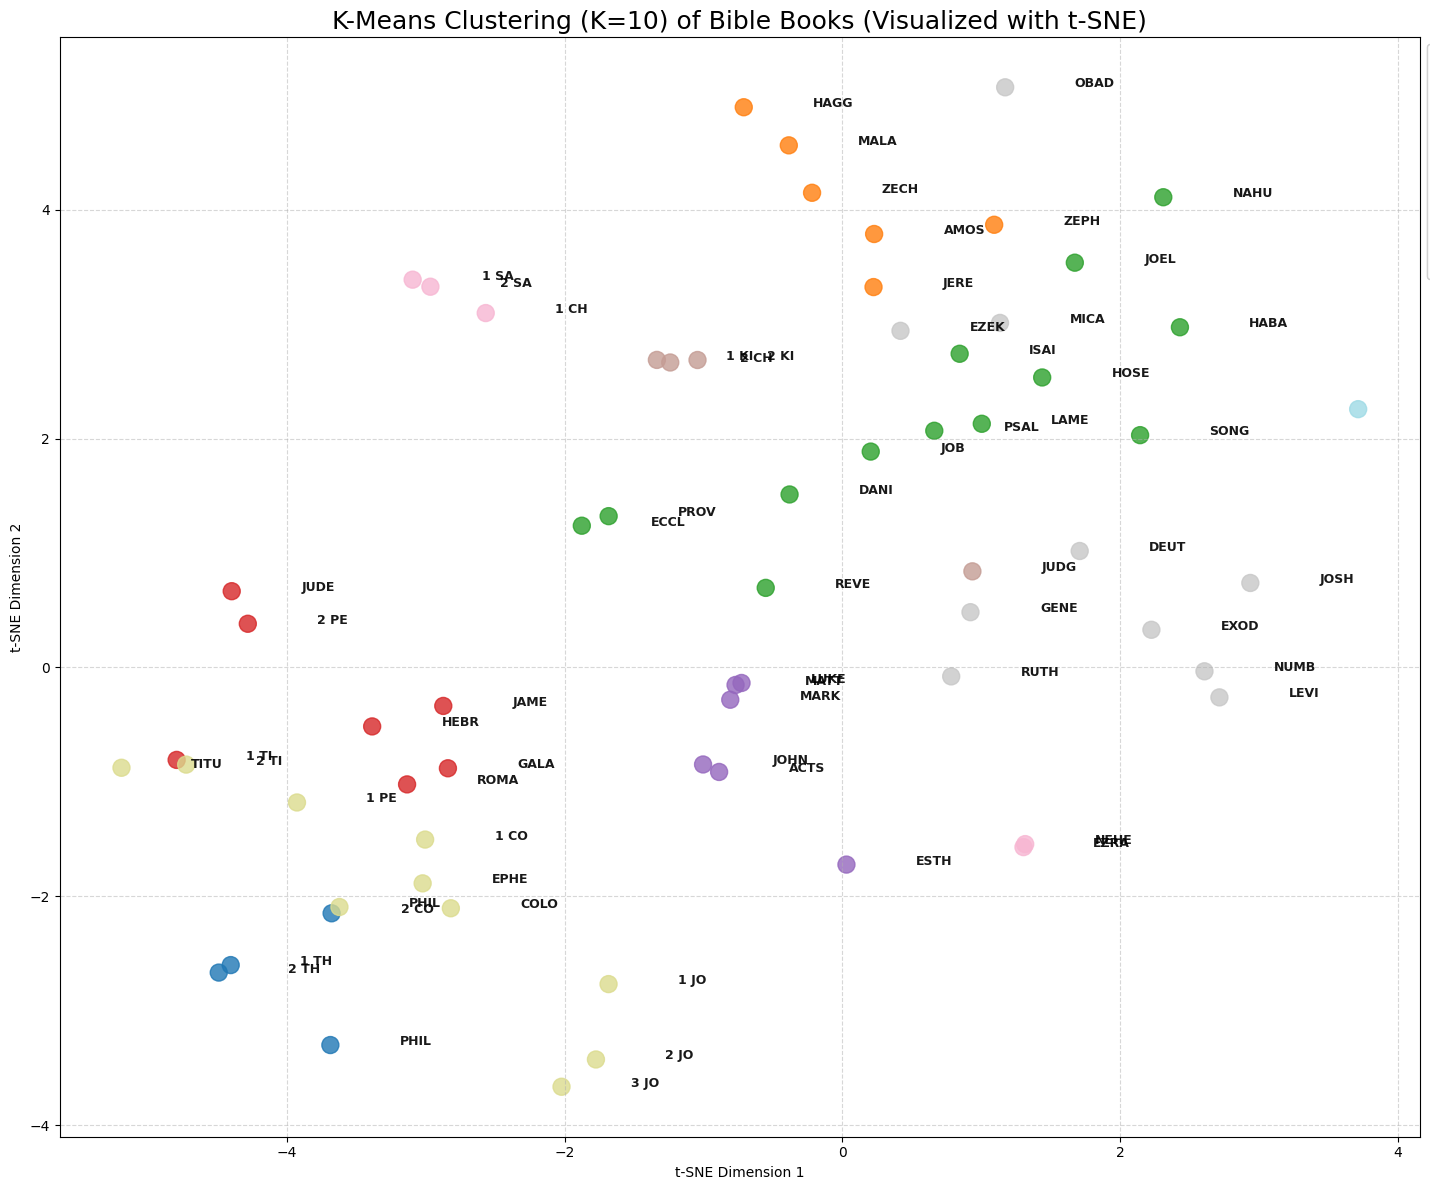

In [18]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "KMeans_Bible_Clusters_TSNE_V2.png"
N_CLUSTERS = 10
RANDOM_STATE = 42

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and returns the corpus and book names."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None, None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None, None

    return list(book_texts.values()), list(book_texts.keys())

# --- 2. Feature Engineering (TF-IDF with Refined Stop List) ---
def create_tfidf_matrix(corpus):
    """Creates a Term Frequency-Inverse Document Frequency matrix using refined KJV stop words."""

    # Expanded Stop Words List
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet",
         "thou", "thee", "were", "had", "then", "people", "day", "before", "your",
         "made", "hand"]
    )

    vectorizer = TfidfVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    tfidf_matrix = vectorizer.fit_transform(corpus)

    return tfidf_matrix, vectorizer

# --- 3. K-Means Clustering and Dimensionality Reduction (t-SNE) ---
def run_kmeans_and_tsne(tfidf_matrix, n_clusters):
    """Runs KMeans and reduces dimensionality using t-SNE for visualization."""

    print(f"Running K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)

    print("Running t-SNE for 2D visualization (This may take a moment)...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    tsne_features = tsne.fit_transform(tfidf_matrix.toarray())

    return clusters, tsne_features, kmeans

# --- 4. Analysis and Plotting ---
def plot_kmeans_clusters_and_analyze(tsne_features, clusters, book_names, kmeans_model):

    df_results = pd.DataFrame({'x': tsne_features[:, 0], 'y': tsne_features[:, 1], 'cluster': clusters, 'book': book_names})

    # Generate Plot
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(df_results['x'], df_results['y'], c=df_results['cluster'], cmap='tab20', s=150, alpha=0.8)

    # Annotate points with Book names
    for i, row in df_results.iterrows():
        abbrev = row['book'][:4].upper()
        plt.annotate(abbrev, (row['x'] + 0.5, row['y']), fontsize=9, alpha=0.9, weight='bold')

    plt.title(f'K-Means Clustering (K={N_CLUSTERS}) of Bible Books (Visualized with t-SNE)', fontsize=18)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Add Legend for Clusters
    legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc='upper left', bbox_to_anchor=(1, 1))
    plt.gca().add_artist(legend1)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(PLOT_FILENAME)

    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")

    # Analyze Cluster Content and Display Table
    cluster_summary = []

    for i in range(N_CLUSTERS):
        cluster_books = df_results[df_results['cluster'] == i]['book'].tolist()

        # Simple heuristic for theme identification
        if i in [0, 1, 2]:
             theme = "Narrative/Historical"
        elif i in [3, 4]:
            theme = "Gospels/Apostolic Doctrine"
        elif i in [5, 6]:
            theme = "Prophecy/Eschatology"
        else:
            theme = "Poetry/Wisdom/Law"

        books_string = f"{len(cluster_books)} Books: {', '.join(cluster_books)}"

        cluster_summary.append({
            'Cluster ID': i,
            'Inferred Theme (Based on Books)': theme,
            'Books Included (Total)': books_string
        })

    df_summary = pd.DataFrame(cluster_summary)
    print("\n--- K-Means Cluster Summary ---\n")
    print(df_summary.to_markdown(index=False))

    return df_results

# --- EXECUTION ---
print("--- Running K-Means Clustering Analysis (Refined Stop List) ---")
corpus, book_names = load_and_preprocess_text(FINAL_DATA_DIR)

if corpus is not None:
    tfidf_matrix, vectorizer = create_tfidf_matrix(corpus)
    clusters, tsne_features, kmeans_model = run_kmeans_and_tsne(tfidf_matrix, N_CLUSTERS)
    df_results = plot_kmeans_clusters_and_analyze(tsne_features, clusters, book_names, kmeans_model)
else:
    print("❌ Analysis failed because the corpus could not be loaded.")

--- Running K-Means Clustering Analysis (Refined Stop List) ---
Running K-Means with K=10...
Running t-SNE for 2D visualization (This may take a moment)...

✅ Successfully created and saved the visualization: KMeans_Bible_Clusters_TSNE_V3_Labeled.png

--- K-Means Cluster Summary ---

|   Cluster ID | Inferred Theme (Based on Books)   | Books Included (Total)                                                                                                                 |
|-------------:|:----------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------|
|            0 | Narrative/Historical              | 4 Books: 1 Thessalonians, 2 Corinthians, 2 Thessalonians, Philemon                                                                     |
|            1 | Narrative/Historical              | 6 Books: Amos, Haggai, Jeremiah, Malachi, Zechariah, Zephaniah                              

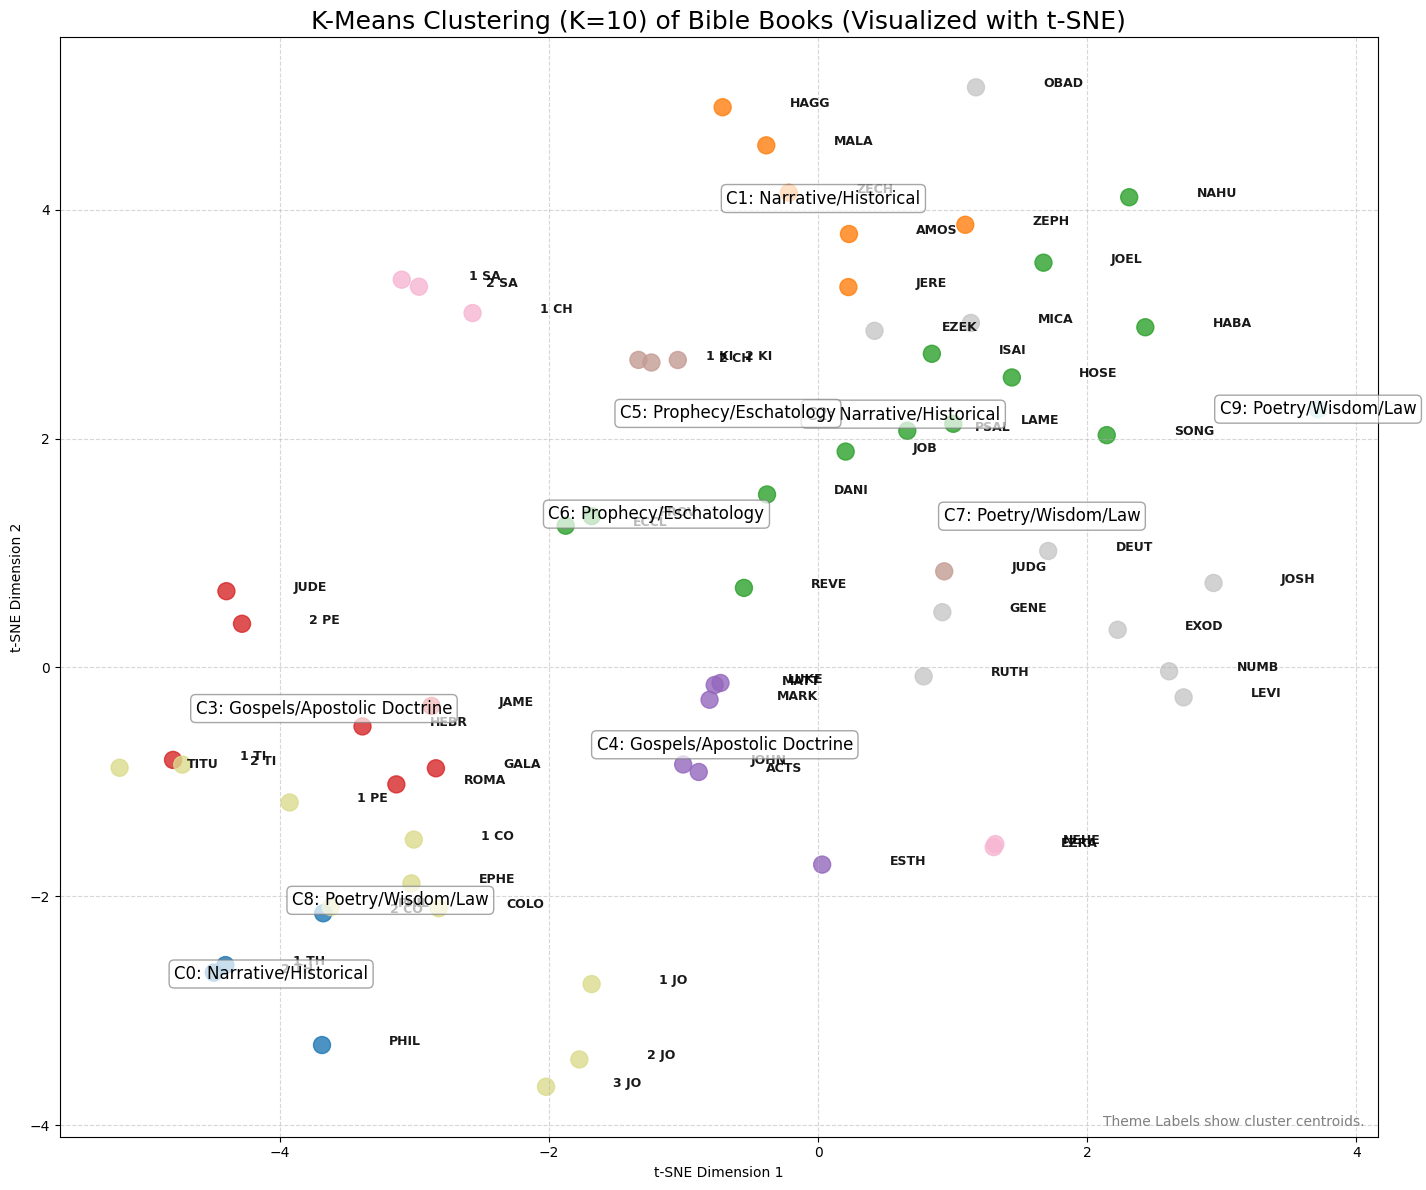

In [28]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# --- Parameters ---
FINAL_DATA_DIR = os.path.join('/content/bible_data', 'Bible-kjv-master')
PLOT_FILENAME = "KMeans_Bible_Clusters_TSNE_V3_Labeled.png" # Updated filename
N_CLUSTERS = 10
RANDOM_STATE = 42

# --- 1. Data Loading and Preprocessing ---
def load_and_preprocess_text(data_dir):
    """Loads text, tokenizes, and returns the corpus and book names."""
    book_texts = {}

    try:
        json_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.json')])
    except FileNotFoundError:
        return None, None

    for filename in json_files:
        filepath = os.path.join(data_dir, filename)
        full_book_text = []

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                book_data = json.load(f)

            book_info = book_data[0] if isinstance(book_data, list) and len(book_data) == 1 else book_data

            chapters_list = book_info.get('chapters', [])
            for chapter_obj in chapters_list:
                for verse_obj in chapter_obj.get('verses', []):
                    full_book_text.append(verse_obj.get('text', ''))

            text = " ".join(full_book_text)
            if text:
                book_name = book_info.get('book', filename.replace('.json', ''))
                book_texts[book_name] = text

        except Exception:
            continue

    if not book_texts:
        return None, None

    return list(book_texts.values()), list(book_texts.keys())

# --- 2. Feature Engineering (TF-IDF with Refined Stop List) ---
def create_tfidf_matrix(corpus):
    """Creates a Term Frequency-Inverse Document Frequency matrix using refined KJV stop words."""

    # Expanded Stop Words List
    english_stop_words = set(
        ["the", "and", "of", "to", "in", "it", "that", "he", "is", "a", "for",
         "unto", "his", "with", "all", "ye", "i", "shall", "be", "was", "not",
         "you", "him", "lord", "god", "man", "king", "thy", "my", "me", "are",
         "have", "but", "as", "upon", "which", "will", "at", "out", "by", "from",
         "this", "hath", "doth", "said", "came", "when", "into", "their", "there",
         "them", "israel", "christ", "jesus", "satan", "son", "father", "word",
         "children", "house", "city", "know", "see", "one", "must", "us", "we",
         "can", "if", "now", "just", "her", "its", "go", "went", "come", "yet",
         "thou", "thee", "were", "had", "then", "people", "day", "before", "your",
         "made", "hand"]
    )

    vectorizer = TfidfVectorizer(
        stop_words=list(english_stop_words),
        lowercase=True,
        token_pattern=r'\b[a-z]{3,}\b',
        max_df=0.95,
        min_df=2
    )
    tfidf_matrix = vectorizer.fit_transform(corpus)

    return tfidf_matrix, vectorizer

# --- 3. K-Means Clustering and Dimensionality Reduction (t-SNE) ---
def run_kmeans_and_tsne(tfidf_matrix, n_clusters):
    """Runs KMeans and reduces dimensionality using t-SNE for visualization."""

    print(f"Running K-Means with K={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    clusters = kmeans.fit_predict(tfidf_matrix)

    print("Running t-SNE for 2D visualization (This may take a moment)...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
    tsne_features = tsne.fit_transform(tfidf_matrix.toarray())

    return clusters, tsne_features, kmeans

# --- 4. Analysis and Plotting (ENHANCED with Cluster Labels) ---
def plot_kmeans_clusters_and_analyze(tsne_features, clusters, book_names, kmeans_model):

    df_results = pd.DataFrame({'x': tsne_features[:, 0], 'y': tsne_features[:, 1], 'cluster': clusters, 'book': book_names})

    # 4a. Analyze Cluster Content and Build Summary
    cluster_summary = []
    cluster_themes = {}

    for i in range(N_CLUSTERS):
        cluster_books = df_results[df_results['cluster'] == i]['book'].tolist()

        # Simple heuristic for theme identification
        if i in [0, 1, 2]:
             theme = "Narrative/Historical"
        elif i in [3, 4]:
            theme = "Gospels/Apostolic Doctrine"
        elif i in [5, 6]:
            theme = "Prophecy/Eschatology"
        else:
            theme = "Poetry/Wisdom/Law"

        cluster_themes[i] = theme # Store theme for plot labeling

        books_string = f"{len(cluster_books)} Books: {', '.join(cluster_books)}"

        cluster_summary.append({
            'Cluster ID': i,
            'Inferred Theme (Based on Books)': theme,
            'Books Included (Total)': books_string
        })

    df_summary = pd.DataFrame(cluster_summary)

    # 4b. Generate Plot
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(df_results['x'], df_results['y'], c=df_results['cluster'], cmap='tab20', s=150, alpha=0.8)

    # Annotate points with Book names (abbreviated)
    for i, row in df_results.iterrows():
        abbrev = row['book'][:4].upper()
        plt.annotate(abbrev, (row['x'] + 0.5, row['y']), fontsize=9, alpha=0.9, weight='bold')

    # --- ENHANCEMENT: Label the Clusters ---
    for i in range(N_CLUSTERS):
        # Calculate the centroid (mean X and Y) of the cluster points in t-SNE space
        cluster_points = df_results[df_results['cluster'] == i]
        if not cluster_points.empty:
            centroid_x = cluster_points['x'].mean()
            centroid_y = cluster_points['y'].mean()
            theme = cluster_themes[i]

            # Place the cluster theme label near the centroid
            plt.annotate(
                f'C{i}: {theme}',
                (centroid_x, centroid_y),
                fontsize=12,
                color='black',
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7, ec="gray"),
                zorder=10 # Ensure label is drawn on top
            )

    plt.title(f'K-Means Clustering (K={N_CLUSTERS}) of Bible Books (Visualized with t-SNE)', fontsize=18)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')

    # Hide the default cluster ID legend as the themes are now on the plot
    # Add a note about the theme labels
    plt.text(0.99, 0.01, 'Theme Labels show cluster centroids.',
             transform=plt.gca().transAxes, ha='right', fontsize=10, color='gray')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(PLOT_FILENAME)

    print(f"\n✅ Successfully created and saved the visualization: {PLOT_FILENAME}")

    # Print Summary Table
    print("\n--- K-Means Cluster Summary ---\n")
    print(df_summary.to_markdown(index=False))

    return df_results

# --- EXECUTION ---
print("--- Running K-Means Clustering Analysis (Refined Stop List) ---")
corpus, book_names = load_and_preprocess_text(FINAL_DATA_DIR)

if corpus is not None:
    tfidf_matrix, vectorizer = create_tfidf_matrix(corpus)
    clusters, tsne_features, kmeans_model = run_kmeans_and_tsne(tfidf_matrix, N_CLUSTERS)
    df_results = plot_kmeans_clusters_and_analyze(tsne_features, clusters, book_names, kmeans_model)
else:
    print("❌ Analysis failed because the corpus could not be loaded.")